# Introduction

The goal of this project is to determine the factors that directly contribute to student success for this online program. Previous EDA showed that the distributions of numeric data did not differ between passing and failing students. Since there are both continuous and categorical values to predict the student outcome, 

## Loading libraries

In [111]:
# Standard
import os
import random
from datetime import datetime, timedelta
import itertools
from subprocess import call
from io import StringIO
import time
import pickle

# Manipulation
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from scipy import stats, optimize, spatial

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image
import graphviz
import pydotplus

# Modeling
from sklearn import datasets, svm, decomposition
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, Normalizer, RobustScaler
from sklearn.datasets import make_classification

# Metrics
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from sklearn.metrics import silhouette_score, silhouette_samples

## Loading statistical functions

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def pearson_r(x , y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size = 1):
    """perform pairs bootstrap for linear regression"""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def draw_bs_pairs(x, y, func, size = 1):
    """Perform pairs bootstrap for a single statistic."""
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def diff_frac(data_A, data_b):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

def rmse(pred, obs):
    return np.sqrt(((pred - obs) ** 2).mean())

def mse(pred, obs):
    return ((pred - obs) ** 2).mean()

def bon_correct(alpha, n):
    return (alpha/n)

# Loading Data

In [7]:
df = pd.read_csv('capstone_2_modeling_v2.csv')
with open('region_map.pkl', 'rb') as f:
    region_map = pickle.load(f)

with open('activity_map.pkl', 'rb') as file:
    activity_map = pickle.load(file)

In [8]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [9]:
df.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,date_registration,num_of_prev_attempts,final_result,studied_credits,activity_type,mean_score,mean_assessment_length,max_assessment_length,mean_active,total_active,mean_clicks,clicks
0,2412002,0,0,2,5686,5,2,-38,0,Distinction,90,9783,84.25,63.625,171,4.0,4,11.000000,11
1,2412002,0,0,2,5686,5,2,-38,0,Distinction,90,15664,84.25,63.625,171,1.0,3,5.333333,16
2,2412002,0,0,2,5686,5,2,-38,0,Distinction,90,11403,84.25,63.625,171,3.0,3,6.000000,6
3,2412002,0,0,2,5686,5,2,-38,0,Distinction,90,10272,84.25,63.625,171,2.5,5,11.500000,23
4,2412002,0,0,2,5686,5,2,-38,0,Distinction,90,5981,84.25,63.625,171,2.0,2,3.000000,3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72305 entries, 0 to 72304
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_student              72305 non-null  int64  
 1   gender                  72305 non-null  int64  
 2   disability              72305 non-null  int64  
 3   age_band                72305 non-null  int64  
 4   region                  72305 non-null  int64  
 5   imd_band                72305 non-null  int64  
 6   highest_education       72305 non-null  int64  
 7   date_registration       72305 non-null  int64  
 8   num_of_prev_attempts    72305 non-null  int64  
 9   final_result            72305 non-null  object 
 10  studied_credits         72305 non-null  int64  
 11  activity_type           72305 non-null  int64  
 12  mean_score              72305 non-null  float64
 13  mean_assessment_length  72305 non-null  float64
 14  max_assessment_length   72305 non-null

In [11]:
df.describe()

,id_student,gender,disability,age_band,region,imd_band,highest_education,date_registration,num_of_prev_attempts,studied_credits,activity_type,mean_score,mean_assessment_length,max_assessment_length,mean_active,total_active,mean_clicks,clicks
count,7.230500e+04,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.000000,72305.00000
mean,7.136373e+05,0.392158,0.080658,1.316838,6256.934251,4.503409,2.822184,-64.656649,0.139230,75.746836,9807.248696,75.507870,103.061030,164.890851,2.089066,7.119203,6.297755,23.47514
std,5.685251e+05,0.488235,0.272312,0.483412,1767.818949,2.822728,0.734119,40.937335,0.439077,32.128242,4126.458900,14.974022,42.343092,59.488002,2.006748,13.171022,8.463833,51.89753
min,6.516000e+03,0.000000,0.000000,1.000000,2035.000000,0.000000,1.000000,-172.000000,0.000000,30.000000,2.000000,0.000000,-6.000000,-6.000000,1.000000,1.000000,1.000000,1.00000
25%,5.001120e+05,0.000000,0.000000,1.000000,4912.000000,2.000000,2.000000,-93.000000,0.000000,60.000000,7666.000000,67.560000,76.923077,131.000000,1.000000,2.000000,2.000000,3.00000
50%,5.845670e+05,0.000000,0.000000,1.000000,6262.000000,4.000000,3.000000,-53.000000,0.000000,60.000000,10272.000000,78.222222,103.380952,178.000000,1.250000,4.000000,3.400000,8.00000
75%,6.348330e+05,1.000000,0.000000,2.000000,7558.000000,7.000000,3.000000,-29.000000,0.000000,90.000000,11403.000000,86.421053,127.906977,209.000000,2.500000,8.000000,7.000000,23.00000
max,2.698535e+06,1.000000,1.000000,3.000000,8989.000000,9.000000,5.000000,-10.000000,6.000000,180.000000,15664.000000,100.000000,236.857143,243.000000,42.909091,472.000000,232.375000,1859.00000


In [12]:
df.shape

(72305, 19)

# Splitting the Data

Now that the data has been encoded, it can now be split into its respective x and y variables. The 'final_result' feature was left untouched since it was the response variable to all the other features. For x data, 'id_student' will be dropped since it serves as more of a categorical variable.

Since the data points were originally ordered by assessment and student, I will need to shuffle the train_test to make sure students at the bottom of the df do not unnecessarily get cut.

In [14]:
x = df.drop(columns = ['id_student', 'final_result'])
y = df[['final_result']]

features = x.columns.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 6022, stratify = y, test_size = 0.25, shuffle = True)

# Scaling

Despite encoding, a few columns are still beyond a comparable scope of eachother. A StandardScaler will be applied to ensure that all values are comparable.

In [16]:
scaler = Normalizer()
scaler_model = scaler.fit(x_train)

In [17]:
x_train_scale = scaler_model.transform(x_train)
x_test_scale = scaler_model.transform(x_test)

In [18]:
cv_k = StratifiedKFold(5)
n_est_first = [2**i for i in range(7)]
n_est_second = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]
n_est = n_est_first + n_est_second
n_iter = 200
verb = 4 #Extremely long training times for hypertuning required me to make sure that progress was being made

# Simple Decision Tree

In [20]:
dt_params = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [int(x) for x in np.linspace(10, 90, num = 9)],
    'min_samples_split': [x for x in np.linspace(0.01, 0.5, 10, endpoint = True)]
}

cv_dt = DecisionTreeClassifier(max_features = 'sqrt', random_state = 6022)

In [21]:
start_time = time.time()
dt_rand = RandomizedSearchCV(
    estimator = cv_dt,
    param_distributions = dt_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
dt_rand_cv = dt_rand.fit(x_train_scale, y_train)
end_time = time.time()
dt_cv_time = end_time - start_time

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 180 is smaller than n_iter=200. Running 180 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.01;, score=(train=0.661, test=0.654) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.01;, score=(train=0.657, test=0.653) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.01;, score=(train=0.652, test=0.643) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.01;, score=(train=0.653, test=0.643) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.01;, score=(train=0.654, test=0.650) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.06444444444444444;, score=(train=0.649, test=0.647) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.06444444444444444;, score=(train=0.635, test=0.637) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=10, min_sam

In [22]:
print("Best Score:" + str(dt_rand_cv.best_score_))
print("Best Parameters: " + str(dt_rand_cv.best_params_))

Best Score:0.6502175551819951
Best Parameters: {'min_samples_split': 0.01, 'max_depth': 10, 'criterion': 'gini'}


In [23]:
dt = DecisionTreeClassifier(**dt_rand_cv.best_params_, max_features = 'sqrt', random_state = 6022)

start_time = time.time()
dt_model = dt.fit(x_train_scale, y_train)
end_time = time.time()
dt_fit_time = end_time - start_time

start_time = time.time()
dt_pred = dt_model.predict(x_test_scale)
end_time = time.time()
dt_pred_time = end_time - start_time

dt_cv_scores_test = cross_val_score(dt_model, x_test_scale, y_test, cv = cv_k, scoring = 'roc_auc')
dt_cv_scores_train = cross_val_score(dt_model, x_train_scale, y_train, cv = cv_k, scoring = 'roc_auc')
print(f'Training CV Score: {dt_cv_scores_train.mean()} +- {dt_cv_scores_train.std()}')
print(f'Testing CV Score: {dt_cv_scores_test.mean()} +- {dt_cv_scores_test.std()}')

Because of the heavy class imbalance, the models cannot be compared using cross-validation scores. The metrics obtained from the confusion matrix will be how the final model is selected.

In [127]:
with open('dt_rand_cv.pkl', 'wb') as f:
    pickle.dump(dt_rand_cv, f)

with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)

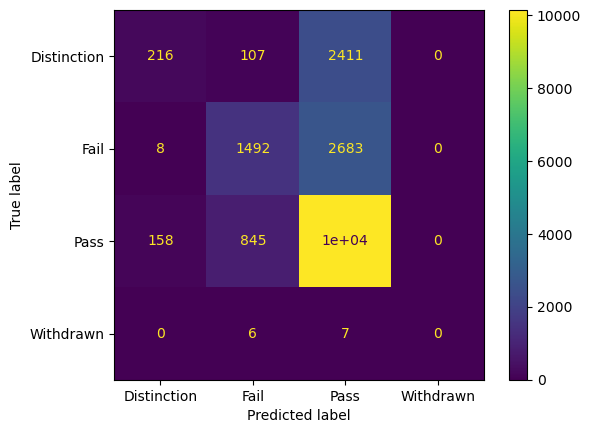

In [26]:
dt_confusion = confusion_matrix(y_test, dt_pred, labels = dt_model.classes_)
dt_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = dt_confusion, display_labels = dt_model.classes_)
dt_confusion_matrix.plot()
plt.show()

In [27]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

 Distinction       0.57      0.08      0.14      2734
        Fail       0.61      0.36      0.45      4183
        Pass       0.67      0.91      0.77     11147
   Withdrawn       0.00      0.00      0.00        13

    accuracy                           0.66     18077
   macro avg       0.46      0.34      0.34     18077
weighted avg       0.64      0.66      0.60     18077



C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


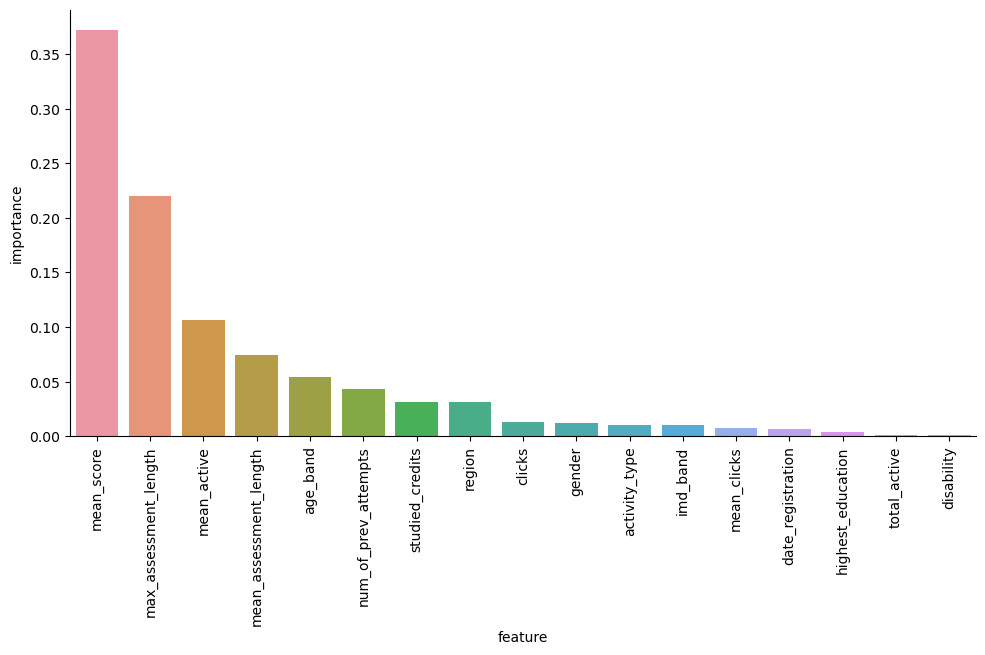

In [28]:
dt_imp = dt_model.feature_importances_
dt_feat_imp_df = pd.DataFrame({'feature': features, 'importance': dt_imp})
dt_sorted = dt_feat_imp_df.sort_values(by = 'importance', ascending = False)
dt_feat_plot = sns.catplot(data = dt_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
dt_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [29]:
print(f'CV time: {dt_cv_time}')
print(f'Fit time: {dt_fit_time}')
print(f'Predict time: {dt_pred_time}')

CV time: 171.643061876297
Fit time: 0.19609832763671875
Predict time: 0.0030031204223632812


# Random Forest

In [31]:
rf_params = {
    'n_estimators': n_est,
    'criterion': ['gini', 'entropy'],
    'max_depth': [int(x) for x in np.linspace(10, 90, num = 9)],
    'min_samples_split': [x for x in np.linspace(0.01, 0.5, 10, endpoint = True)]
}

cv_rf = RandomForestClassifier(max_features = 'sqrt', n_jobs = 6, random_state = 6022)

In [32]:
start_time = time.time()
rf_rand = RandomizedSearchCV(
    estimator = cv_rf,
    param_distributions = rf_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
rf_rand_cv = rf_rand.fit(x_train_scale, y_train)
end_time = time.time()
rf_cv_time = end_time - start_time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.627, test=0.627) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.621, test=0.623) total time=   6.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.624, test=0.623) total time=   7.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.628, test=0.626) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.626, test=0.626) total time=   7.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.629, test=0.632) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.630, test=0.635) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.632, test=0.634) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.632, test=0.630) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.632, test=0.624) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.649) total time=  16.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.651, test=0.656) total time=  16.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.650) total time=  16.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.651, test=0.651) total time=  17.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.648) total time=  17.1s
[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.625, test=0.622) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.624, test=0.625) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.625, test=0.626) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.624, test=0.624) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.644) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.644, test=0.649) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.645) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.646) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.642) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1300;, score=(train=0.669, test=0.665) total time=  25.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1300;, score=(train=0.670, test=0.666) total time=  24.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1300;, score=(train=0.669, test=0.665) total time=  24.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1300;, score=(train=0.669, test=0.664) total time=  25.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1300;, score=(train=0.671, test=0.659) total time=  25.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=300;, score=(train=0.649, test=0.646) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=300;, score=(train=0.648, test=0.653) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=300;, score=(train=0.648, test=0.647) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=300;, score=(train=0.650, test=0.649) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=300;, score=(train=0.650, test=0.646) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.649, test=0.647) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.647, test=0.653) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.648, test=0.645) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.648, test=0.648) total time=   9.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.649, test=0.646) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.5, n_estimators=600;, score=(train=0.626, test=0.626) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.5, n_estimators=600;, score=(train=0.623, test=0.621) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.5, n_estimators=600;, score=(train=0.625, test=0.625) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.5, n_estimators=600;, score=(train=0.622, test=0.623) total time=   3.0s
[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.638, test=0.635) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.625, test=0.625) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.645, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.644, test=0.643) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.645, test=0.642) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.649, test=0.647) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.647, test=0.653) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.648, test=0.645) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.648, test=0.648) total time=   9.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.649, test=0.646) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.652, test=0.648) total time=   6.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.650, test=0.655) total time=   6.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.652, test=0.650) total time=   6.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.651, test=0.651) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.652, test=0.648) total time=   6.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1500;, score=(train=0.650, test=0.647) total time=  15.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1500;, score=(train=0.648, test=0.653) total time=  15.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1500;, score=(train=0.649, test=0.648) total time=  15.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1500;, score=(train=0.650, test=0.649) total time=  15.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1500;, score=(train=0.650, test=0.647) total time=  15.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.01, n_estimators=64;, score=(train=0.667, test=0.664) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.01, n_estimators=64;, score=(train=0.668, test=0.664) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.01, n_estimators=64;, score=(train=0.667, test=0.663) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.01, n_estimators=64;, score=(train=0.668, test=0.665) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.01, n_estimators=64;, score=(train=0.668, test=0.658) total time=   1.6s
[CV 1/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.645, test=0.641) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.642, test=0.647) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.649, test=0.648) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.647, test=0.646) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.643, test=0.639) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=16;, score=(train=0.629, test=0.627) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=16;, score=(train=0.625, test=0.626) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=16;, score=(train=0.639, test=0.638) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=16;, score=(train=0.626, test=0.629) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=16;, score=(train=0.640, test=0.637) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.647, test=0.643) total time=   7.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.640, test=0.645) total time=   7.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.646, test=0.644) total time=   7.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.643, test=0.641) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.647, test=0.644) total time=   7.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.628, test=0.627) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.622, test=0.622) total time=   6.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.624, test=0.623) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.628, test=0.626) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.626, test=0.627) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.637, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.638, test=0.641) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.639, test=0.640) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.642, test=0.641) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.641, test=0.636) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.639, test=0.640) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.636, test=0.640) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.642, test=0.643) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.644, test=0.643) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.646, test=0.642) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.649, test=0.646) total time=   6.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.648, test=0.653) total time=   6.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.648, test=0.647) total time=   6.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.649, test=0.649) total time=   6.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.650, test=0.647) total time=   6.3s
[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.649) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.655) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.650) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.652) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.648) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.648, test=0.646) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.645, test=0.650) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.645, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.646, test=0.645) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.646, test=0.645) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.642, test=0.637) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.647, test=0.654) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.644, test=0.644) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.649, test=0.648) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.649, test=0.646) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.644, test=0.640) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.641, test=0.646) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.647, test=0.646) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.647, test=0.647) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.647, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.647, test=0.642) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.641, test=0.644) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.645, test=0.645) total time=   3.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.647, test=0.646) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.645, test=0.643) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.650, test=0.647) total time=   6.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.648, test=0.654) total time=   7.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.649, test=0.648) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.650, test=0.649) total time=   6.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.650, test=0.647) total time=   6.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.649, test=0.646) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.648, test=0.653) total time=   5.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.648, test=0.647) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.649, test=0.649) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.650, test=0.646) total time=   5.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   5.1s
[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.631, test=0.630) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.638, test=0.641) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.638, test=0.638) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.639, test=0.639) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.638, test=0.635) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.648, test=0.648) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.647, test=0.652) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.648, test=0.646) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.648, test=0.647) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.649, test=0.644) total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.641, test=0.636) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.646, test=0.654) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.644, test=0.643) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.648, test=0.647) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.649, test=0.647) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1500;, score=(train=0.667, test=0.663) total time=  38.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1500;, score=(train=0.669, test=0.665) total time=  38.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1500;, score=(train=0.668, test=0.663) total time=  38.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1500;, score=(train=0.667, test=0.665) total time=  38.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1500;, score=(train=0.668, test=0.657) total time=  38.9s
[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   4.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=1300;, score=(train=0.649, test=0.647) total time=  17.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=1300;, score=(train=0.647, test=0.653) total time=  17.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=1300;, score=(train=0.648, test=0.646) total time=  17.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=1300;, score=(train=0.648, test=0.648) total time=  17.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=1300;, score=(train=0.649, test=0.645) total time=  16.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.644) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.644, test=0.649) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.645) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.646) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.647, test=0.642) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=1100;, score=(train=0.626, test=0.622) total time=  10.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=1100;, score=(train=0.621, test=0.621) total time=  10.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=1100;, score=(train=0.623, test=0.625) total time=   9.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=1100;, score=(train=0.627, test=0.627) total time=  10.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=1100;, score=(train=0.628, test=0.628) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.649, test=0.646) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.646, test=0.651) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.647, test=0.648) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.647, test=0.646) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.648, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.650, test=0.647) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.648, test=0.653) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.649, test=0.648) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.650, test=0.649) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.650, test=0.646) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.617, test=0.617) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.617, test=0.617) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.617, test=0.617) total time=   5.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.619, test=0.620) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.619, test=0.620) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.650, test=0.651) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.650, test=0.655) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.650, test=0.648) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.651, test=0.650) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.652, test=0.646) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.01, n_estimators=1;, score=(train=0.656, test=0.648) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.01, n_estimators=1;, score=(train=0.646, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.01, n_estimators=1;, score=(train=0.652, test=0.645) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.01, n_estimators=1;, score=(train=0.652, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.01, n_estimators=1;, score=(train=0.649, test=0.637) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=16;, score=(train=0.665, test=0.662) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=16;, score=(train=0.668, test=0.665) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=16;, score=(train=0.668, test=0.663) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=16;, score=(train=0.670, test=0.665) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=16;, score=(train=0.666, test=0.656) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.628, test=0.628) total time=   6.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.622, test=0.623) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.625, test=0.623) total time=   6.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.628, test=0.626) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.626, test=0.627) total time=   6.9s
[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.629, test=0.630) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.624, test=0.628) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.630, test=0.629) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.624, test=0.626) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.632, test=0.631) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.636, test=0.633) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.632, test=0.633) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.636, test=0.637) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.634, test=0.631) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.633, test=0.631) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1300;, score=(train=0.631, test=0.629) total time=   8.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1300;, score=(train=0.625, test=0.627) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1300;, score=(train=0.628, test=0.626) total time=   7.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1300;, score=(train=0.631, test=0.629) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1300;, score=(train=0.627, test=0.629) total time=   8.2s
[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   6.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   5.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.647, test=0.645) total time=  12.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.643, test=0.648) total time=  12.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.647, test=0.644) total time=  12.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.646, test=0.646) total time=  12.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.648, test=0.645) total time=  12.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.631, test=0.629) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.631, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.633, test=0.636) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.637, test=0.636) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.637, test=0.633) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=1000;, score=(train=0.628, test=0.628) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=1000;, score=(train=0.623, test=0.624) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=1000;, score=(train=0.626, test=0.624) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=1000;, score=(train=0.628, test=0.626) total time=   5.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=1000;, score=(train=0.626, test=0.627) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.652, test=0.649) total time=  14.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.651, test=0.656) total time=  16.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.652, test=0.650) total time=  15.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.651, test=0.651) total time=  15.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.652, test=0.648) total time=  16.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.646, test=0.642) total time=   6.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.638, test=0.643) total time=   6.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.643, test=0.642) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.642, test=0.640) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.646, test=0.643) total time=   5.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.645, test=0.641) total time=  11.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.638, test=0.643) total time=  11.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.644, test=0.643) total time=  11.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.642, test=0.640) total time=  11.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.647, test=0.644) total time=  12.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.629, test=0.629) total time=   9.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.624, test=0.626) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.626, test=0.624) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.630, test=0.628) total time=   8.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.627, test=0.628) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.648, test=0.645) total time=   4.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.647, test=0.654) total time=   4.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.649, test=0.647) total time=   4.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.649, test=0.648) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.649, test=0.646) total time=   4.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.649, test=0.645) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.647, test=0.652) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.648, test=0.647) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.649, test=0.649) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.650, test=0.646) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.646, test=0.641) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.640, test=0.644) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.642, test=0.644) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.646, test=0.644) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.645, test=0.643) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.632, test=0.628) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.626, test=0.628) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.628, test=0.630) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.630, test=0.629) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.633, test=0.631) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.642, test=0.637) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.634, test=0.638) total time=   8.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.638, test=0.639) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.639, test=0.638) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.639, test=0.637) total time=   7.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=500;, score=(train=0.669, test=0.665) total time=  10.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=500;, score=(train=0.670, test=0.666) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=500;, score=(train=0.669, test=0.665) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=500;, score=(train=0.669, test=0.665) total time=  10.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=500;, score=(train=0.671, test=0.659) total time=  10.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.649, test=0.646) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.648, test=0.653) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.649, test=0.647) total time=   4.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.650, test=0.649) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.650, test=0.646) total time=   4.8s
[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.17333333333333334, n_estimators=4;, score=(train=0.642, test=0.639) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.17333333333333334, n_estimators=4;, score=(train=0.644, test=0.650) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.17333333333333334, n_estimators=4;, score=(train=0.642, test=0.640) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.17333333333333334, n_estimators=4;, score=(train=0.645, test=0.644) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.17333333333333334, n_estimators=4;, score=(train=0.648, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=300;, score=(train=0.629, test=0.628) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=300;, score=(train=0.625, test=0.625) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=300;, score=(train=0.627, test=0.625) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=300;, score=(train=0.628, test=0.626) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=300;, score=(train=0.627, test=0.627) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.648, test=0.647) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.646, test=0.650) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.649, test=0.647) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.647, test=0.646) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.648, test=0.645) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=900;, score=(train=0.624, test=0.623) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=900;, score=(train=0.617, test=0.617) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=900;, score=(train=0.621, test=0.620) total time=   4.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=900;, score=(train=0.623, test=0.623) total time=   4.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=900;, score=(train=0.620, test=0.620) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.628, test=0.628) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.622, test=0.623) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.627, test=0.625) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.628, test=0.626) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.626, test=0.627) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.648, test=0.645) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.647, test=0.653) total time=   8.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.648, test=0.647) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.649, test=0.648) total time=   8.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.649, test=0.646) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.01, n_estimators=700;, score=(train=0.669, test=0.665) total time=  14.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.01, n_estimators=700;, score=(train=0.670, test=0.665) total time=  14.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.01, n_estimators=700;, score=(train=0.669, test=0.665) total time=  14.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.01, n_estimators=700;, score=(train=0.669, test=0.664) total time=  14.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.01, n_estimators=700;, score=(train=0.670, test=0.659) total time=  14.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.629, test=0.630) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.624, test=0.628) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.630, test=0.629) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.624, test=0.626) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.632, test=0.631) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.648, test=0.653) total time=   9.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.649, test=0.647) total time=   9.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.649) total time=  10.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=  10.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.629, test=0.629) total time=   9.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.624, test=0.626) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.626, test=0.624) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.630, test=0.628) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.627, test=0.628) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.640, test=0.638) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.638, test=0.644) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.639, test=0.637) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.639, test=0.639) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.644, test=0.640) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.648, test=0.645) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.647, test=0.653) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.648, test=0.647) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.649, test=0.648) total time=   9.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1100;, score=(train=0.649, test=0.646) total time=   9.2s
[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.636, test=0.635) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.641) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.638) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.639) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.635) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.649, test=0.647) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.647, test=0.653) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.648, test=0.646) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.648, test=0.648) total time=   6.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.649, test=0.646) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.618, test=0.618) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.617, test=0.617) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.618, test=0.617) total time=   5.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.619, test=0.619) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.619, test=0.620) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   8.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   8.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   8.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1400;, score=(train=0.650, test=0.647) total time=  15.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1400;, score=(train=0.648, test=0.653) total time=  14.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1400;, score=(train=0.649, test=0.648) total time=  15.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1400;, score=(train=0.650, test=0.649) total time=  15.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1400;, score=(train=0.650, test=0.647) total time=  14.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.648, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.645, test=0.652) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.647, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.648, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.648, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.629, test=0.629) total time=   4.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.623, test=0.625) total time=   4.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.628, test=0.627) total time=   4.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.629, test=0.626) total time=   4.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.628, test=0.627) total time=   4.7s
[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.629, test=0.630) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.624, test=0.628) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.630, test=0.629) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.624, test=0.626) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.632, test=0.631) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.2s
[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.642, test=0.637) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.647, test=0.654) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.644, test=0.644) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.649, test=0.648) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.649, test=0.646) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.642, test=0.637) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.634, test=0.637) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.638, test=0.639) total time=  10.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.639, test=0.638) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.638, test=0.637) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=300;, score=(train=0.636, test=0.633) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=300;, score=(train=0.630, test=0.631) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=300;, score=(train=0.634, test=0.634) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=300;, score=(train=0.635, test=0.636) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.2822222222222222, n_estimators=300;, score=(train=0.640, test=0.636) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.01, n_estimators=1;, score=(train=0.656, test=0.648) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.01, n_estimators=1;, score=(train=0.646, test=0.643) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.01, n_estimators=1;, score=(train=0.652, test=0.645) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.01, n_estimators=1;, score=(train=0.652, test=0.644) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.01, n_estimators=1;, score=(train=0.649, test=0.637) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.644, test=0.641) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.647, test=0.653) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.644, test=0.642) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.649, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.648, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.3911111111111111, n_estimators=900;, score=(train=0.632, test=0.631) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.3911111111111111, n_estimators=900;, score=(train=0.625, test=0.627) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.3911111111111111, n_estimators=900;, score=(train=0.629, test=0.628) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.3911111111111111, n_estimators=900;, score=(train=0.631, test=0.629) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.3911111111111111, n_estimators=900;, score=(train=0.628, test=0.629) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.627, test=0.624) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.624, test=0.625) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.626, test=0.628) total time=   7.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.629, test=0.629) total time=   7.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.630, test=0.629) total time=   7.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=   9.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.648, test=0.653) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.649, test=0.647) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.649) total time=  10.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=  10.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.634, test=0.633) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.629, test=0.632) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.631, test=0.628) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.633, test=0.631) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.632, test=0.632) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.649) total time=  19.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.651, test=0.656) total time=  18.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.650) total time=  18.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.651, test=0.651) total time=  19.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.648) total time=  18.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.649, test=0.646) total time=   9.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.648, test=0.653) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.648, test=0.647) total time=   9.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.649, test=0.648) total time=   9.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.650, test=0.646) total time=  10.5s
[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.642, test=0.637) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.634, test=0.637) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.638, test=0.639) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.639, test=0.638) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.638, test=0.637) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   3.4s
[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=2;, score=(train=0.640, test=0.634) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=2;, score=(train=0.643, test=0.651) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=2;, score=(train=0.643, test=0.641) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=2;, score=(train=0.645, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=2;, score=(train=0.649, test=0.647) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.628, test=0.625) total time=   6.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.624, test=0.624) total time=   6.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.628, test=0.629) total time=   6.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.630, test=0.629) total time=   7.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.631, test=0.629) total time=   6.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.650, test=0.647) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.648, test=0.654) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.649, test=0.648) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.650, test=0.649) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.650, test=0.647) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.629, test=0.628) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.623, test=0.623) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.627, test=0.626) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.629, test=0.626) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.626, test=0.627) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=300;, score=(train=0.629, test=0.628) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=300;, score=(train=0.625, test=0.625) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=300;, score=(train=0.627, test=0.625) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=300;, score=(train=0.628, test=0.626) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.5, n_estimators=300;, score=(train=0.627, test=0.627) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.635, test=0.631) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.630, test=0.632) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.636, test=0.634) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.639, test=0.637) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.636, test=0.633) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=   9.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.648, test=0.653) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.649, test=0.647) total time=   9.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.649) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.644, test=0.640) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.641, test=0.646) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.647, test=0.646) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.647, test=0.647) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.647, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.643, test=0.639) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.635, test=0.639) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.638, test=0.641) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.641, test=0.640) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.639, test=0.638) total time=   4.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=  10.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.648, test=0.653) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.649, test=0.647) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.649) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=900;, score=(train=0.650, test=0.647) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.650, test=0.647) total time=  12.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.648, test=0.653) total time=  12.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.649, test=0.647) total time=  11.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.650, test=0.649) total time=  11.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.650, test=0.647) total time=  11.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.623, test=0.621) total time=  14.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.620, test=0.620) total time=  14.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.621, test=0.622) total time=  14.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.625, test=0.625) total time=  14.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.626, test=0.626) total time=  14.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.649) total time=  18.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.651, test=0.656) total time=  18.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.650) total time=  18.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.651, test=0.651) total time=  18.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=1100;, score=(train=0.652, test=0.648) total time=  19.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.649, test=0.646) total time=  10.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.648, test=0.653) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.648, test=0.647) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.649, test=0.648) total time=   9.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1000;, score=(train=0.650, test=0.646) total time=   9.3s
[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.649, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.641, test=0.646) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.649, test=0.648) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.642, test=0.641) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.649, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.01, n_estimators=900;, score=(train=0.667, test=0.664) total time=  15.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.01, n_estimators=900;, score=(train=0.668, test=0.665) total time=  15.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.01, n_estimators=900;, score=(train=0.668, test=0.664) total time=  15.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.01, n_estimators=900;, score=(train=0.667, test=0.663) total time=  15.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.01, n_estimators=900;, score=(train=0.669, test=0.658) total time=  15.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1;, score=(train=0.656, test=0.648) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1;, score=(train=0.646, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1;, score=(train=0.652, test=0.645) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1;, score=(train=0.652, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.01, n_estimators=1;, score=(train=0.649, test=0.637) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.636, test=0.635) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.641) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.638) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.639) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.638, test=0.635) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.649, test=0.647) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.647, test=0.653) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.648, test=0.646) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.648, test=0.648) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=200;, score=(train=0.649, test=0.646) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.629, test=0.629) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.624, test=0.626) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.626, test=0.624) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.630, test=0.628) total time=   9.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1400;, score=(train=0.627, test=0.628) total time=   8.6s
[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.5, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.5, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.5, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.5, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.5, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.617, test=0.617) total time=   3.6s
[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.22777777777777777, n_estimators=1;, score=(train=0.645, test=0.640) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.22777777777777777, n_estimators=1;, score=(train=0.636, test=0.640) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.22777777777777777, n_estimators=1;, score=(train=0.648, test=0.648) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.22777777777777777, n_estimators=1;, score=(train=0.643, test=0.640) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.22777777777777777, n_estimators=1;, score=(train=0.643, test=0.641) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=1000;, score=(train=0.647, test=0.642) total time=   7.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=1000;, score=(train=0.640, test=0.644) total time=   7.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=1000;, score=(train=0.644, test=0.644) total time=   7.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=1000;, score=(train=0.646, test=0.645) total time=   8.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.2822222222222222, n_estimators=1000;, score=(train=0.645, test=0.643) total time=   7.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.649, test=0.646) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.648, test=0.654) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.648, test=0.648) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.649, test=0.648) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.650, test=0.646) total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.648, test=0.645) total time=   2.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.645, test=0.651) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.647, test=0.645) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.647, test=0.648) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.647, test=0.644) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.650, test=0.647) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.648, test=0.653) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.649, test=0.647) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.650, test=0.649) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.650, test=0.646) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.649, test=0.646) total time=  13.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.648, test=0.653) total time=  13.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.649, test=0.647) total time=  13.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.649, test=0.648) total time=  13.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.650, test=0.646) total time=  13.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1200;, score=(train=0.622, test=0.621) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1200;, score=(train=0.617, test=0.617) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1200;, score=(train=0.618, test=0.618) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1200;, score=(train=0.622, test=0.622) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1200;, score=(train=0.618, test=0.618) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.649, test=0.647) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.641, test=0.646) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.649, test=0.648) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.642, test=0.641) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.649, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.649, test=0.646) total time=   7.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.648, test=0.653) total time=   7.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.648, test=0.647) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.649, test=0.648) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.650, test=0.646) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=100;, score=(train=0.649, test=0.648) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=100;, score=(train=0.647, test=0.653) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=100;, score=(train=0.648, test=0.646) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=100;, score=(train=0.648, test=0.647) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=100;, score=(train=0.649, test=0.645) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.648, test=0.646) total time=  10.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.644, test=0.650) total time=   9.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.647, test=0.645) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.646, test=0.646) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.648, test=0.644) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=8;, score=(train=0.671, test=0.660) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=8;, score=(train=0.671, test=0.667) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=8;, score=(train=0.672, test=0.665) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=8;, score=(train=0.673, test=0.667) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.01, n_estimators=8;, score=(train=0.673, test=0.658) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=16;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=16;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=16;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=16;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=16;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.649, test=0.647) total time=   9.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.647, test=0.653) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.648, test=0.645) total time=   9.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.648, test=0.648) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=700;, score=(train=0.649, test=0.646) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=32;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=32;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=32;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=32;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.44555555555555554, n_estimators=32;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.649, test=0.645) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.647, test=0.652) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.648, test=0.647) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.649, test=0.649) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.650, test=0.646) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.649, test=0.646) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.648, test=0.654) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.648, test=0.648) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.649, test=0.648) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=32;, score=(train=0.650, test=0.646) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.650) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.657) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.650) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.650) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.648) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.648, test=0.646) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.647, test=0.652) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.647, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.648, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.11888888888888888, n_estimators=8;, score=(train=0.647, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.628, test=0.628) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.622, test=0.623) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.627, test=0.625) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.628, test=0.626) total time=   5.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.626, test=0.627) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.617, test=0.617) total time=   4.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.617, test=0.617) total time=   4.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.617, test=0.617) total time=   4.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.617, test=0.617) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.617, test=0.617) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.649) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.655) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.650) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.652) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.648) total time=   0.8s
[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.638, test=0.635) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.639, test=0.647) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.642, test=0.642) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.645, test=0.644) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.645, test=0.643) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=400;, score=(train=0.668, test=0.664) total time=  10.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=400;, score=(train=0.669, test=0.665) total time=  10.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=400;, score=(train=0.668, test=0.663) total time=  10.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=400;, score=(train=0.668, test=0.664) total time=  10.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=400;, score=(train=0.669, test=0.657) total time=  11.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1200;, score=(train=0.669, test=0.665) total time=  24.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1200;, score=(train=0.671, test=0.666) total time=  24.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1200;, score=(train=0.669, test=0.665) total time=  25.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1200;, score=(train=0.669, test=0.664) total time=  24.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=1200;, score=(train=0.671, test=0.659) total time=  24.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.649) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.655) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.650) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.651, test=0.652) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=64;, score=(train=0.652, test=0.648) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.646, test=0.641) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.640, test=0.644) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.642, test=0.644) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.646, test=0.644) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.645, test=0.643) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=60, min_samples_split=0.01, n_estimators=16;, score=(train=0.665, test=0.662) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=60, min_samples_split=0.01, n_estimators=16;, score=(train=0.668, test=0.665) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=60, min_samples_split=0.01, n_estimators=16;, score=(train=0.668, test=0.663) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=60, min_samples_split=0.01, n_estimators=16;, score=(train=0.670, test=0.665) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=60, min_samples_split=0.01, n_estimators=16;, score=(train=0.666, test=0.656) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.647, test=0.642) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.640, test=0.644) total time=   6.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.645, test=0.644) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.646, test=0.644) total time=   6.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.645, test=0.643) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.617, test=0.617) total time=   7.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.617, test=0.617) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.617, test=0.617) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.617, test=0.617) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.617, test=0.617) total time=   7.4s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.5, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=16;, score=(train=0.649, test=0.646) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=16;, score=(train=0.648, test=0.652) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=16;, score=(train=0.647, test=0.646) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=16;, score=(train=0.646, test=0.645) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=16;, score=(train=0.648, test=0.644) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.631, test=0.631) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.628, test=0.631) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.630, test=0.628) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.633, test=0.632) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.630, test=0.629) total time=   3.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=700;, score=(train=0.624, test=0.624) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=700;, score=(train=0.617, test=0.617) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=700;, score=(train=0.622, test=0.620) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=700;, score=(train=0.624, test=0.625) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=700;, score=(train=0.620, test=0.621) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=600;, score=(train=0.626, test=0.626) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=600;, score=(train=0.617, test=0.617) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=600;, score=(train=0.623, test=0.621) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=600;, score=(train=0.625, test=0.625) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=600;, score=(train=0.622, test=0.623) total time=   3.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.635, test=0.631) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.630, test=0.632) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.636, test=0.634) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.639, test=0.637) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.2822222222222222, n_estimators=64;, score=(train=0.636, test=0.633) total time=   0.7s
[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=1200;, score=(train=0.627, test=0.627) total time=   6.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=1200;, score=(train=0.622, test=0.622) total time=   7.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=1200;, score=(train=0.624, test=0.622) total time=   6.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=1200;, score=(train=0.628, test=0.626) total time=   6.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=1200;, score=(train=0.625, test=0.626) total time=   6.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   9.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.617, test=0.617) total time=   9.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.618, test=0.618) total time=   9.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.33666666666666667, n_estimators=1100;, score=(train=0.618, test=0.618) total time=   9.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.649, test=0.645) total time=  14.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.648, test=0.653) total time=  14.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.649, test=0.647) total time=  14.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.650, test=0.648) total time=  14.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=70, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.650, test=0.646) total time=  15.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=300;, score=(train=0.617, test=0.617) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=300;, score=(train=0.617, test=0.617) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.5, n_estimators=300;, score=(train=0.617, test=0.617) total time=   1.7s
[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.641, test=0.636) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.646, test=0.654) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.644, test=0.643) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.648, test=0.647) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.11888888888888888, n_estimators=2;, score=(train=0.649, test=0.647) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.648, test=0.646) total time=   4.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.645, test=0.651) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.647, test=0.645) total time=   4.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.647, test=0.646) total time=   4.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.648, test=0.645) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.652, test=0.649) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.651, test=0.656) total time=   7.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.651, test=0.650) total time=   6.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.651, test=0.650) total time=   6.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.652, test=0.648) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.648, test=0.645) total time=  12.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.647, test=0.653) total time=  10.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.648, test=0.647) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.649, test=0.648) total time=  10.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.649, test=0.646) total time=  10.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.646, test=0.644) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.643, test=0.649) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.647, test=0.644) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.646, test=0.644) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=50, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.647, test=0.644) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.01, n_estimators=500;, score=(train=0.669, test=0.665) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.01, n_estimators=500;, score=(train=0.670, test=0.666) total time=  10.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.01, n_estimators=500;, score=(train=0.669, test=0.665) total time=  10.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.01, n_estimators=500;, score=(train=0.669, test=0.665) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.01, n_estimators=500;, score=(train=0.671, test=0.659) total time=  10.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=64;, score=(train=0.667, test=0.664) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=64;, score=(train=0.668, test=0.664) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=64;, score=(train=0.667, test=0.663) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=64;, score=(train=0.668, test=0.665) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.01, n_estimators=64;, score=(train=0.668, test=0.658) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.648, test=0.645) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.647, test=0.654) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.648, test=0.647) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.649, test=0.648) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.650, test=0.646) total time=   5.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.629, test=0.629) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.623, test=0.625) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.628, test=0.627) total time=   3.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.629, test=0.627) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=0.44555555555555554, n_estimators=600;, score=(train=0.627, test=0.628) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=0.01, n_estimators=1500;, score=(train=0.665, test=0.663) total time=  37.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=0.01, n_estimators=1500;, score=(train=0.668, test=0.664) total time=  35.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=0.01, n_estimators=1500;, score=(train=0.667, test=0.663) total time=  34.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=0.01, n_estimators=1500;, score=(train=0.666, test=0.665) total time=  34.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=0.01, n_estimators=1500;, score=(train=0.668, test=0.657) total time=  34.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.645, test=0.641) total time=  12.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.638, test=0.642) total time=  12.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.644, test=0.643) total time=  12.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.642, test=0.640) total time=  12.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.22777777777777777, n_estimators=1200;, score=(train=0.647, test=0.644) total time=  12.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=300;, score=(train=0.669, test=0.665) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=300;, score=(train=0.670, test=0.665) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=300;, score=(train=0.669, test=0.665) total time=   6.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=300;, score=(train=0.670, test=0.664) total time=   5.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.01, n_estimators=300;, score=(train=0.671, test=0.659) total time=   6.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.617, test=0.617) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.647, test=0.643) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.644, test=0.647) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.647, test=0.647) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.647, test=0.645) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.646, test=0.642) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=200;, score=(train=0.624, test=0.624) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=200;, score=(train=0.620, test=0.620) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=200;, score=(train=0.624, test=0.624) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=200;, score=(train=0.621, test=0.622) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.33666666666666667, n_estimators=200;, score=(train=0.628, test=0.629) total time=   1.8s
[CV 1/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.644, test=0.642) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.641, test=0.648) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.643, test=0.641) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.642, test=0.641) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=90, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.642, test=0.640) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=30, min_samples_split=0.06444444444444444, n_estimators=4;, score=(train=0.650, test=0.649) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=30, min_samples_split=0.06444444444444444, n_estimators=4;, score=(train=0.650, test=0.653) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=30, min_samples_split=0.06444444444444444, n_estimators=4;, score=(train=0.648, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_split=0.06444444444444444, n_estimators=4;, score=(train=0.648, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=30, min_samples_split=0.06444444444444444, n_estimators=4;, score=(train=0.651, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=60, min_samples_split=0.5, n_estimators=1400;, score=(train=0.617, test=0.617) total time=   9.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=60, min_samples_split=0.5, n_estimators=1400;, score=(train=0.617, test=0.617) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=60, min_samples_split=0.5, n_estimators=1400;, score=(train=0.617, test=0.617) total time=   8.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=60, min_samples_split=0.5, n_estimators=1400;, score=(train=0.617, test=0.617) total time=   8.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=60, min_samples_split=0.5, n_estimators=1400;, score=(train=0.617, test=0.617) total time=   8.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=60, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.617, test=0.617) total time=   2.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.638, test=0.635) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.625, test=0.625) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.645, test=0.644) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.644, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.44555555555555554, n_estimators=16;, score=(train=0.645, test=0.642) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.627, test=0.627) total time=   8.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.621, test=0.623) total time=   8.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.624, test=0.623) total time=   8.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.628, test=0.626) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=30, min_samples_split=0.44555555555555554, n_estimators=1400;, score=(train=0.626, test=0.626) total time=   8.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.650, test=0.647) total time=  13.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.648, test=0.653) total time=  13.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.649, test=0.648) total time=  13.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.650, test=0.649) total time=  13.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.650, test=0.647) total time=  13.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=700;, score=(train=0.624, test=0.624) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=700;, score=(train=0.617, test=0.617) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=700;, score=(train=0.622, test=0.620) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=700;, score=(train=0.624, test=0.625) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=80, min_samples_split=0.5, n_estimators=700;, score=(train=0.620, test=0.621) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.628, test=0.626) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.624, test=0.625) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.625, test=0.626) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.624, test=0.626) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=40, min_samples_split=0.2822222222222222, n_estimators=4;, score=(train=0.624, test=0.624) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.619, test=0.623) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.619, test=0.622) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.623, test=0.623) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.628, test=0.625) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=70, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.619, test=0.616) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.631, test=0.629) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.631, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.633, test=0.636) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.637, test=0.636) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=50, min_samples_split=0.3911111111111111, n_estimators=32;, score=(train=0.637, test=0.633) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [33]:
print("Best Score:" + str(rf_rand_cv.best_score_))
print("Best Parameters: " + str(rf_rand_cv.best_params_))

Best Score:0.6638451715185743
Best Parameters: {'n_estimators': 500, 'min_samples_split': 0.01, 'max_depth': 70, 'criterion': 'gini'}


In [34]:
rf = RandomForestClassifier(**rf_rand_cv.best_params_, max_features = 'sqrt', random_state = 6022)

start_time = time.time()
rf_model = rf.fit(x_train_scale, y_train)
end_time = time.time()
rf_fit_time = end_time - start_time

start_time = time.time()
rf_pred = rf_model.predict(x_test_scale)
end_time = time.time()
rf_pred_time = end_time - start_time

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [125]:
with open('rf_rand_cv.pkl', 'wb') as f:
    pickle.dump(rf_rand_cv, f)

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

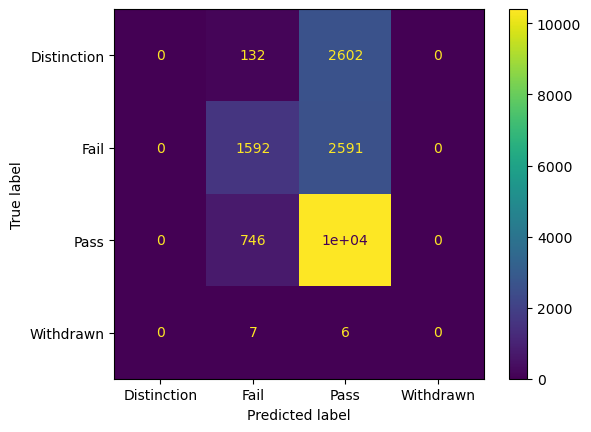

In [35]:
rf_confusion = confusion_matrix(y_test, rf_pred, labels = rf_model.classes_)
rf_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = rf_confusion, display_labels = rf_model.classes_)
rf_confusion_matrix.plot()
plt.show()

In [36]:
print(classification_report(y_test, rf_pred))

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Distinction       0.00      0.00      0.00      2734
        Fail       0.64      0.38      0.48      4183
        Pass       0.67      0.93      0.78     11147
   Withdrawn       0.00      0.00      0.00        13

    accuracy                           0.66     18077
   macro avg       0.33      0.33      0.31     18077
weighted avg       0.56      0.66      0.59     18077



C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


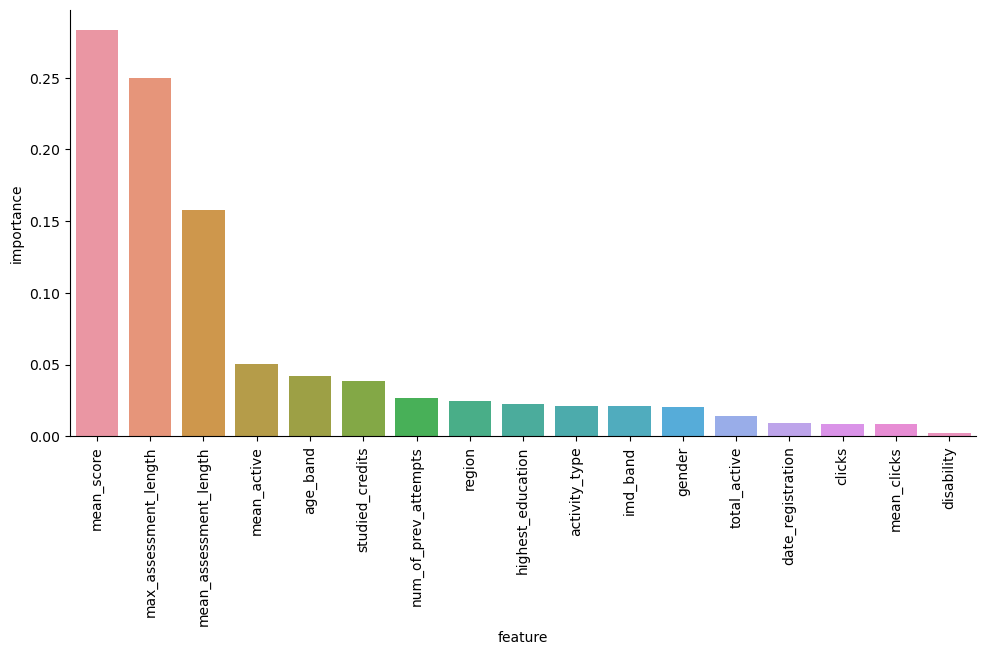

In [37]:
rf_imp = rf_model.feature_importances_
rf_feat_imp_df = pd.DataFrame({'feature': features, 'importance': rf_imp})
rf_sorted = rf_feat_imp_df.sort_values(by = 'importance', ascending = False)
rf_feat_plot = sns.catplot(data = rf_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
rf_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [38]:
print(f'CV time: {rf_cv_time}')
print(f'Fit time: {rf_fit_time}')
print(f'Predict time: {rf_pred_time}')

CV time: 5211.724515199661
Fit time: 62.70606255531311
Predict time: 0.6633079051971436


# K-Nearest Neighbors

In [40]:
knn_params = {
    'n_neighbors': n_est_first,
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

cv_knn = KNeighborsClassifier(n_jobs = 6)

In [41]:
start_time = time.time()
knn_rand = RandomizedSearchCV(
    estimator = cv_knn,
    param_distributions = knn_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
knn_rand_cv = knn_rand.fit(x_train_scale, y_train)
end_time = time.time()
knn_cv_time = end_time - start_time

Fitting 5 folds for each of 56 candidates, totalling 280 fits


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 56 is smaller than n_iter=200. Running 56 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users

[CV 1/5] END algorithm=auto, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/5] END algorithm=auto, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=auto, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 4/5] END algorithm=auto, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 3/5] END algorithm=auto, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 2/5] END algorithm=auto, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 1/5] END algorithm=auto, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=auto, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 4/5] END algorithm=auto, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 3/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py

[CV 2/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 1/5] END algorithm=auto, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=auto, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 3/5] END algorithm=auto, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py

[CV 2/5] END algorithm=auto, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 1/5] END algorithm=auto, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 4/5] END algorithm=auto, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 2/5] END algorithm=auto, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=auto, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 3/5] END algorithm=auto, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.559) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.557) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.550) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.550) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.559) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.559) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.557) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.550) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.550) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.559) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform;, score=(train=0.789, test=0.488) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform;, score=(train=0.791, test=0.484) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform;, score=(train=0.792, test=0.484) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform;, score=(train=0.792, test=0.485) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform;, score=(train=0.789, test=0.491) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.559) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.557) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.550) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.549) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.559) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=4, weights=uniform;, score=(train=0.747, test=0.584) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=4, weights=uniform;, score=(train=0.746, test=0.589) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=4, weights=uniform;, score=(train=0.746, test=0.586) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=4, weights=uniform;, score=(train=0.749, test=0.586) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=4, weights=uniform;, score=(train=0.749, test=0.585) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.606) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.611) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.608) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.604) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.607) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.701, test=0.634) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.700, test=0.635) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.703, test=0.629) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.701, test=0.628) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.700, test=0.629) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.638) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.640) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.634) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.634) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.634) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.651) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=16, weights=uniform;, score=(train=0.671, test=0.654) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.647) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.647) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.648) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.648) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.654) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.647) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.648) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.647) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=32, weights=uniform;, score=(train=0.660, test=0.652) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=32, weights=uniform;, score=(train=0.657, test=0.659) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=32, weights=uniform;, score=(train=0.660, test=0.652) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=32, weights=uniform;, score=(train=0.659, test=0.650) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=32, weights=uniform;, score=(train=0.660, test=0.651) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.650) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.657) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.651) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.651) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.649) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=64, weights=uniform;, score=(train=0.654, test=0.647) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=64, weights=uniform;, score=(train=0.651, test=0.656) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=64, weights=uniform;, score=(train=0.654, test=0.650) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=64, weights=uniform;, score=(train=0.653, test=0.649) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=64, weights=uniform;, score=(train=0.655, test=0.648) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.646) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.655) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.651) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=ball_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.651) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.645) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.559) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.557) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.550) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.550) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=1, weights=uniform;, score=(train=0.998, test=0.559) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.559) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.557) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.550) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.550) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=1, weights=distance;, score=(train=0.998, test=0.559) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=2, weights=uniform;, score=(train=0.789, test=0.488) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=2, weights=uniform;, score=(train=0.791, test=0.484) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=2, weights=uniform;, score=(train=0.792, test=0.484) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=2, weights=uniform;, score=(train=0.792, test=0.485) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=2, weights=uniform;, score=(train=0.789, test=0.491) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.559) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.557) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.550) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.549) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=2, weights=distance;, score=(train=0.998, test=0.559) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=4, weights=uniform;, score=(train=0.747, test=0.584) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=4, weights=uniform;, score=(train=0.746, test=0.589) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=4, weights=uniform;, score=(train=0.746, test=0.586) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=4, weights=uniform;, score=(train=0.749, test=0.586) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=4, weights=uniform;, score=(train=0.749, test=0.585) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.606) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.611) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.608) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.604) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=4, weights=distance;, score=(train=0.998, test=0.607) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.701, test=0.634) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.700, test=0.636) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.703, test=0.629) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.701, test=0.628) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.700, test=0.629) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.638) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.641) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.998, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.651) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=16, weights=uniform;, score=(train=0.671, test=0.654) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.647) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.647) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=16, weights=uniform;, score=(train=0.672, test=0.648) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.648) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.654) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.647) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.648) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=16, weights=distance;, score=(train=0.998, test=0.647) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=32, weights=uniform;, score=(train=0.660, test=0.652) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=32, weights=uniform;, score=(train=0.657, test=0.659) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=32, weights=uniform;, score=(train=0.660, test=0.652) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=32, weights=uniform;, score=(train=0.659, test=0.650) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=32, weights=uniform;, score=(train=0.660, test=0.651) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.650) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.657) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.651) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.651) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=32, weights=distance;, score=(train=0.998, test=0.649) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=64, weights=uniform;, score=(train=0.654, test=0.647) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=64, weights=uniform;, score=(train=0.651, test=0.656) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=64, weights=uniform;, score=(train=0.654, test=0.650) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=64, weights=uniform;, score=(train=0.653, test=0.649) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=64, weights=uniform;, score=(train=0.655, test=0.648) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=kd_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.646) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=kd_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.655) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=kd_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.651) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END algorithm=kd_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.651) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=kd_tree, n_neighbors=64, weights=distance;, score=(train=0.998, test=0.645) total time=   0.4s
[CV 1/5] END algorithm=brute, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py

[CV 4/5] END algorithm=brute, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 3/5] END algorithm=brute, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 2/5] END algorithm=brute, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=2, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 1/5] END algorithm=brute, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 5/5] END algorithm=brute, n_neighbors=2, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 4/5] END algorithm=brute, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=4, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 3/5] END algorithm=brute, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=4, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 2/5] END algorithm=brute, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=brute, n_neighbors=8, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 4/5] END algorithm=brute, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=8, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 2/5] END algorithm=brute, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=brute, n_neighbors=16, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py

[CV 4/5] END algorithm=brute, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=16, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 2/5] END algorithm=brute, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 5/5] END algorithm=brute, n_neighbors=32, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 3/5] END algorithm=brute, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=32, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 1/5] END algorithm=brute, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in predict
    probabil

[CV 4/5] END algorithm=brute, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=64, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

[CV 2/5] END algorithm=brute, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=64, weights=distance;, score=(train=nan, test=nan) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 274, in predict
    neigh_di

In [42]:
print("Best Score:" + str(knn_rand_cv.best_score_))
print("Best Parameters: " + str(knn_rand_cv.best_params_))

Best Score:0.6525963616367865
Best Parameters: {'weights': 'uniform', 'n_neighbors': 32, 'algorithm': 'ball_tree'}


In [63]:
knn = KNeighborsClassifier(**knn_rand_cv.best_params_)

start_time = time.time()
knn_model = knn.fit(x_train_scale, y_train)
end_time = time.time()
knn_fit_time = end_time - start_time

start_time = time.time()
knn_pred = knn_model.predict(x_test_scale)
end_time = time.time()
knn_pred_time = end_time - start_time

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [123]:
with open('knn_rand_cv.pkl', 'wb') as f:
    pickle.dump(knn_rand_cv, f)

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

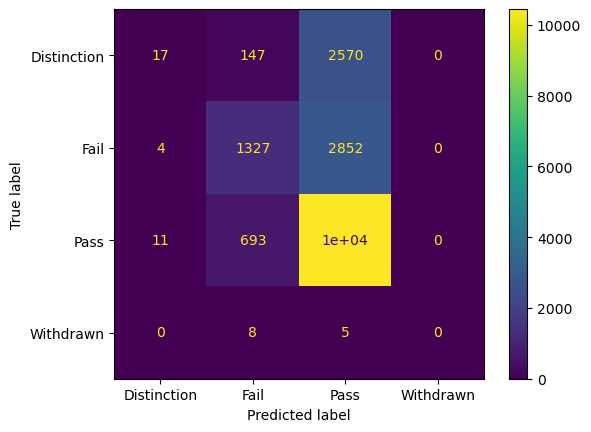

In [65]:
knn_confusion = confusion_matrix(y_test, knn_pred, labels = knn_model.classes_)
knn_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = knn_confusion, display_labels = knn_model.classes_)
knn_confusion_matrix.plot()
plt.show()

In [67]:
print(classification_report(y_test, knn_pred))

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Distinction       0.53      0.01      0.01      2734
        Fail       0.61      0.32      0.42      4183
        Pass       0.66      0.94      0.77     11147
   Withdrawn       0.00      0.00      0.00        13

    accuracy                           0.65     18077
   macro avg       0.45      0.32      0.30     18077
weighted avg       0.63      0.65      0.58     18077



C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [71]:
print(f'CV time: {knn_cv_time}')
print(f'Fit time: {knn_fit_time}')
print(f'Predict time: {knn_pred_time}')

CV time: 506.8193004131317
Fit time: 0.16687917709350586
Predict time: 3.9922475814819336


# Logistic Regression

In [73]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': [0.001, 0.1, 1, 10, 100]
}

cv_lr = LogisticRegression(n_jobs = 6, random_state = 6022)

In [75]:
start_time = time.time()
lr_rand = RandomizedSearchCV(
    estimator = cv_lr,
    param_distributions = lr_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
lr_rand_cv = lr_rand.fit(x_train_scale, y_train)
end_time = time.time()
lr_cv_time = end_time - start_time

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 120 is smaller than n_iter=200. Running 120 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils

[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s
[CV 1/5] END C=0.001, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.001, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=newton-cholesky;, score=(train=nan, t

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.001, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.001, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.001, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.001, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.001, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.001, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.001, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.001, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.001, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.001, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.001, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.001, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.001, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.001, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.001, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.001, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.001, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.001, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.001, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.001, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.001, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.001, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.001, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.001, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.001, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.7s
[CV 1/5] END C=0.001, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.001, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.001, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.001, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.001, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.001, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.001, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.001, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.001, penalty=elasticnet, solver=liblinea

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=0.1, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.618) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=0.1, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=0.1, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=0.1, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=0.1, penalty=l1, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.5s
[CV 1/5] END C=0.1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.619, test=0.618) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.618, test=0.618) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.618, test=0.619) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.618, test=0.618) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.618, test=0.618) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.5s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=(train=nan

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=1, penalty=l1, solver=liblinear;, score=(train=0.641, test=0.638) total time=   2.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=1, penalty=l1, solver=liblinear;, score=(train=0.639, test=0.642) total time=   2.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=1, penalty=l1, solver=liblinear;, score=(train=0.641, test=0.641) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=1, penalty=l1, solver=liblinear;, score=(train=0.640, test=0.639) total time=   2.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=1, penalty=l1, solver=liblinear;, score=(train=0.640, test=0.640) total time=   2.9s
[CV 1/5] END C=1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1, penalty=l1, solver=saga;, score=(train=0.645, test=0.642) total time=   2.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1, penalty=l1, solver=saga;, score=(train=0.643, test=0.649) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1, penalty=l1, solver=saga;, score=(train=0.646, test=0.644) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1, penalty=l1, solver=saga;, score=(train=0.644, test=0.646) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1, penalty=l1, solver=saga;, score=(train=0.645, test=0.643) total time=   2.9s
[CV 1/5] END C=1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1, penalty=l2, solver=lbfgs;, score=(train=0.617, test=0.617) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=1, penalty=l2, solver=liblinear;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1, penalty=l2, solver=newton-cg;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1, penalty=l2, solver=newton-cholesky;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1, penalty=l2, solver=sag;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1, penalty=l2, solver=saga;, score=(train=0.617, test=0.617) total time=   0.5s
[CV 1/5] END C=1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total ti

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=10, penalty=l1, solver=liblinear;, score=(train=0.644, test=0.641) total time=   5.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=10, penalty=l1, solver=liblinear;, score=(train=0.642, test=0.645) total time=   5.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=10, penalty=l1, solver=liblinear;, score=(train=0.644, test=0.643) total time=   5.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=10, penalty=l1, solver=liblinear;, score=(train=0.642, test=0.645) total time=   5.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=10, penalty=l1, solver=liblinear;, score=(train=0.644, test=0.641) total time=   5.5s
[CV 1/5] END C=10, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[C

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, penalty=l1, solver=saga;, score=(train=0.647, test=0.643) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, penalty=l1, solver=saga;, score=(train=0.644, test=0.651) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, penalty=l1, solver=saga;, score=(train=0.647, test=0.643) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, penalty=l1, solver=saga;, score=(train=0.646, test=0.647) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, penalty=l1, solver=saga;, score=(train=0.646, test=0.645) total time=   3.0s
[CV 1/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.635, test=0.629) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.629, test=0.631) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.630, test=0.630) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.636, test=0.636) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.632, test=0.633) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=(train=0.626, test=0.624) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=(train=0.624, test=0.625) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=(train=0.625, test=0.626) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=(train=0.624, test=0.623) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=10, penalty=l2, solver=liblinear;, score=(train=0.624, test=0.625) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.634, test=0.630) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.631, test=0.634) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.634, test=0.633) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.632, test=0.632) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.633, test=0.634) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, penalty=l2, solver=newton-cholesky;, score=(train=0.626, test=0.624) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, penalty=l2, solver=newton-cholesky;, score=(train=0.624, test=0.625) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, penalty=l2, solver=newton-cholesky;, score=(train=0.625, test=0.626) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, penalty=l2, solver=newton-cholesky;, score=(train=0.624, test=0.623) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, penalty=l2, solver=newton-cholesky;, score=(train=0.624, test=0.625) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, penalty=l2, solver=sag;, score=(train=0.634, test=0.630) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, penalty=l2, solver=sag;, score=(train=0.631, test=0.634) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, penalty=l2, solver=sag;, score=(train=0.634, test=0.633) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, penalty=l2, solver=sag;, score=(train=0.633, test=0.633) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, penalty=l2, solver=sag;, score=(train=0.632, test=0.634) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=10, penalty=l2, solver=saga;, score=(train=0.634, test=0.630) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=10, penalty=l2, solver=saga;, score=(train=0.631, test=0.634) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=10, penalty=l2, solver=saga;, score=(train=0.634, test=0.633) total time=   1.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=10, penalty=l2, solver=saga;, score=(train=0.633, test=0.633) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=10, penalty=l2, solver=saga;, score=(train=0.633, test=0.634) total time=   1.3s
[CV 1/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=100, penalty=l1, solver=liblinear;, score=(train=0.646, test=0.642) total time=   8.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=100, penalty=l1, solver=liblinear;, score=(train=0.645, test=0.647) total time=   9.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=100, penalty=l1, solver=liblinear;, score=(train=0.646, test=0.645) total time=   7.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=100, penalty=l1, solver=liblinear;, score=(train=0.645, test=0.647) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=100, penalty=l1, solver=liblinear;, score=(train=0.645, test=0.644) total time=   8.4s
[CV 1/5] END C=100, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, penalty=l1, solver=saga;, score=(train=0.647, test=0.643) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=100, penalty=l1, solver=saga;, score=(train=0.645, test=0.650) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, penalty=l1, solver=saga;, score=(train=0.648, test=0.643) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=100, penalty=l1, solver=saga;, score=(train=0.646, test=0.647) total time=   3.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=100, penalty=l1, solver=saga;, score=(train=0.646, test=0.646) total time=   3.2s
[CV 1/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.645, test=0.638) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.643, test=0.649) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.648, test=0.647) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.643, test=0.643) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.644, test=0.643) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 1/5] END C=100, penalty=l2, solver=liblinear;, score=(train=0.641, test=0.635) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 2/5] END C=100, penalty=l2, solver=liblinear;, score=(train=0.638, test=0.642) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 3/5] END C=100, penalty=l2, solver=liblinear;, score=(train=0.641, test=0.641) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 4/5] END C=100, penalty=l2, solver=liblinear;, score=(train=0.639, test=0.640) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


[CV 5/5] END C=100, penalty=l2, solver=liblinear;, score=(train=0.640, test=0.640) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.646, test=0.642) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.643, test=0.650) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.645, test=0.643) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.645, test=0.646) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.644, test=0.644) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, penalty=l2, solver=newton-cholesky;, score=(train=0.641, test=0.635) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=100, penalty=l2, solver=newton-cholesky;, score=(train=0.638, test=0.642) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, penalty=l2, solver=newton-cholesky;, score=(train=0.641, test=0.641) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=100, penalty=l2, solver=newton-cholesky;, score=(train=0.639, test=0.640) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=100, penalty=l2, solver=newton-cholesky;, score=(train=0.640, test=0.640) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, penalty=l2, solver=sag;, score=(train=0.646, test=0.642) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=100, penalty=l2, solver=sag;, score=(train=0.643, test=0.650) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, penalty=l2, solver=sag;, score=(train=0.647, test=0.643) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=100, penalty=l2, solver=sag;, score=(train=0.645, test=0.645) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=100, penalty=l2, solver=sag;, score=(train=0.646, test=0.643) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, penalty=l2, solver=saga;, score=(train=0.646, test=0.641) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=100, penalty=l2, solver=saga;, score=(train=0.643, test=0.650) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, penalty=l2, solver=saga;, score=(train=0.647, test=0.644) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=100, penalty=l2, solver=saga;, score=(train=0.645, test=0.646) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, penalty=l2, solver=saga;, score=(train=0.646, test=0.643) total time=   1.9s
[CV 1/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, penalty=elasticnet, solver=liblinear;, score=(train=nan

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
400 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver =

In [76]:
print("Best Score:" + str(lr_rand_cv.best_score_))
print("Best Parameters: " + str(lr_rand_cv.best_params_))

Best Score:0.6458287316279286
Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 10}


In [77]:
lr = LogisticRegression(**lr_rand_cv.best_params_, random_state = 6022)

start_time = time.time()
lr_model = lr.fit(x_train_scale, y_train)
end_time = time.time()
lr_fit_time = end_time - start_time

start_time = time.time()
lr_pred = lr_model.predict(x_test_scale)
end_time = time.time()
lr_pred_time = end_time - start_time

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [121]:
with open('lr_rand_cv.pkl', 'wb') as f:
    pickle.dump(lr_rand_cv, f)

with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

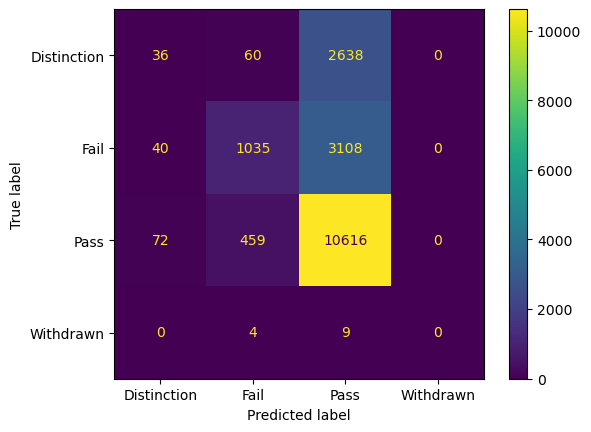

In [78]:
lr_confusion = confusion_matrix(y_test, lr_pred, labels = lr_model.classes_)
lr_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = lr_confusion, display_labels = lr_model.classes_)
lr_confusion_matrix.plot()
plt.show()

In [79]:
print(classification_report(y_test, lr_pred))

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Distinction       0.24      0.01      0.02      2734
        Fail       0.66      0.25      0.36      4183
        Pass       0.65      0.95      0.77     11147
   Withdrawn       0.00      0.00      0.00        13

    accuracy                           0.65     18077
   macro avg       0.39      0.30      0.29     18077
weighted avg       0.59      0.65      0.56     18077



C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [83]:
print(f'CV time: {lr_cv_time}')
print(f'Fit time: {lr_fit_time}')
print(f'Predict time: {lr_pred_time}')

CV time: 273.30328488349915
Fit time: 4.030200719833374
Predict time: 0.0020003318786621094


# Gradient Boosting

In [87]:
gb_params = {
    'n_estimators': n_est,
    'learning_rate': [0.1, 0.25, 0.5, 1],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [int(x) for x in np.linspace(10, 90, num = 9)],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': [x for x in np.linspace(0.01, 0.5, 10, endpoint = True)]
}

cv_gb = GradientBoostingClassifier(random_state = 6022)

In [89]:
start_time = time.time()
gb_rand = RandomizedSearchCV(
    estimator = cv_gb,
    param_distributions = gb_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
gb_rand_cv = gb_rand.fit(x_train_scale, y_train)
end_time = time.time()
gb_cv_time = end_time - start_time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.334, test=0.338) total time= 3.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.404, test=0.413) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.372, test=0.372) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.352, test=0.346) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=700;, score=(train=0.426, test=0.426) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.654, test=0.652) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.653, test=0.658) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.652, test=0.650) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.653, test=0.651) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.656, test=0.651) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.628, test=0.631) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.626, test=0.627) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.629, test=0.628) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.629, test=0.630) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.627, test=0.624) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.743, test=0.687) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.743, test=0.687) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.739, test=0.690) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.742, test=0.683) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.741, test=0.688) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.802, test=0.688) total time= 8.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.801, test=0.692) total time= 8.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.799, test=0.688) total time= 9.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.803, test=0.682) total time= 8.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1000;, score=(train=0.801, test=0.690) total time= 8.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.5, n_estimators=1300;, score=(train=0.806, test=0.685) total time=10.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.5, n_estimators=1300;, score=(train=0.804, test=0.689) total time=10.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.5, n_estimators=1300;, score=(train=0.802, test=0.687) total time= 9.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.5, n_estimators=1300;, score=(train=0.806, test=0.684) total time=10.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.5, n_estimators=1300;, score=(train=0.806, test=0.688) total time=10.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.822, test=0.682) total time=12.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.819, test=0.688) total time=11.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.817, test=0.688) total time=11.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.819, test=0.680) total time=11.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.821, test=0.687) total time=12.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.671) total time=17.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.669) total time=17.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.668) total time=18.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.660) total time=18.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.673) total time=18.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=600;, score=(train=0.998, test=0.688) total time= 7.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=600;, score=(train=0.470, test=0.455) total time= 8.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=600;, score=(train=0.502, test=0.470) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=600;, score=(train=0.998, test=0.681) total time= 8.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=600;, score=(train=0.450, test=0.426) total time= 8.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.673, test=0.668) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.673, test=0.667) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.671, test=0.668) total time=   6.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.672, test=0.666) total time=   6.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.673, test=0.662) total time=   6.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.833, test=0.687) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.829, test=0.692) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.827, test=0.690) total time= 8.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.833, test=0.682) total time= 8.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.830, test=0.690) total time= 8.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.427, test=0.434) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.998, test=0.661) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.462, test=0.462) total time= 4.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.303, test=0.300) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.396, test=0.396) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.295, test=0.294) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.196, test=0.191) total time= 1.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.307, test=0.306) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.877, test=0.659) total time= 3.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.371, test=0.364) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.763, test=0.688) total time= 4.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.762, test=0.693) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.763, test=0.695) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.763, test=0.685) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.762, test=0.689) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.773, test=0.638) total time=  57.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.823, test=0.680) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.702, test=0.599) total time=  44.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.671, test=0.591) total time=  40.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.821, test=0.680) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.638, test=0.638) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.636, test=0.638) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.637, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.632, test=0.634) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.637, test=0.633) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.994, test=0.667) total time=14.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.983, test=0.656) total time=14.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.335, test=0.339) total time= 5.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.995, test=0.664) total time=14.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1000;, score=(train=0.423, test=0.423) total time= 5.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.371, test=0.369) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.998, test=0.668) total time=14.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.399, test=0.386) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.362, test=0.354) total time=11.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.428, test=0.428) total time= 7.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.975, test=0.676) total time= 7.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.974, test=0.674) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.973, test=0.671) total time= 7.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.973, test=0.670) total time= 7.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=500;, score=(train=0.974, test=0.674) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.357, test=0.361) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.428, test=0.431) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.409, test=0.410) total time= 2.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.315, test=0.305) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.449, test=0.446) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.661, test=0.611) total time=  52.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.714, test=0.652) total time=  48.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.778, test=0.688) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.775, test=0.683) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.743, test=0.658) total time= 1.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.448, test=0.447) total time= 5.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.320, test=0.316) total time= 6.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.391, test=0.387) total time= 4.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.338, test=0.339) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.408, test=0.410) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.393, test=0.392) total time= 7.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.998, test=0.662) total time=11.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.368, test=0.364) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.998, test=0.661) total time=11.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.998, test=0.668) total time=11.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.747, test=0.672) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.746, test=0.670) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.751, test=0.669) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.749, test=0.670) total time=   3.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.754, test=0.674) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.229, test=0.234) total time= 5.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.994, test=0.661) total time=10.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.288, test=0.283) total time= 5.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.443, test=0.437) total time= 8.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.473, test=0.466) total time= 5.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.358, test=0.353) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.514, test=0.485) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.396, test=0.387) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.440, test=0.434) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.480, test=0.466) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.264, test=0.254) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.162, test=0.162) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.278, test=0.274) total time= 2.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.203, test=0.205) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.262, test=0.258) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.678, test=0.598) total time= 3.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.834, test=0.642) total time= 4.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.979, test=0.669) total time= 8.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.979, test=0.665) total time= 8.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=500;, score=(train=0.743, test=0.591) total time= 4.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.813, test=0.686) total time= 9.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.811, test=0.691) total time= 9.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.807, test=0.687) total time= 9.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.810, test=0.681) total time= 9.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.810, test=0.688) total time= 9.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.472, test=0.446) total time=13.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.467, test=0.439) total time=12.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.462, test=0.434) total time=13.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.501, test=0.465) total time=13.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.998, test=0.683) total time=13.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.692, test=0.677) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.690, test=0.677) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.693, test=0.682) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.691, test=0.679) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.693, test=0.673) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.433, test=0.430) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.383, test=0.378) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.318, test=0.318) total time= 5.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.262, test=0.265) total time= 5.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.303, test=0.305) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=1200;, score=(train=0.973, test=0.682) total time=15.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=1200;, score=(train=0.975, test=0.686) total time=15.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=1200;, score=(train=0.972, test=0.683) total time=15.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=1200;, score=(train=0.973, test=0.673) total time=15.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=1200;, score=(train=0.973, test=0.685) total time=15.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=1500;, score=(train=0.998, test=0.690) total time=30.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=1500;, score=(train=0.998, test=0.691) total time=31.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=1500;, score=(train=0.998, test=0.687) total time=31.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=1500;, score=(train=0.998, test=0.684) total time=31.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=1500;, score=(train=0.455, test=0.430) total time=35.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.958, test=0.677) total time=20.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.957, test=0.680) total time=20.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.956, test=0.673) total time=20.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.959, test=0.672) total time=20.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1300;, score=(train=0.957, test=0.678) total time=21.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.871, test=0.688) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.875, test=0.693) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.873, test=0.694) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.874, test=0.682) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=500;, score=(train=0.874, test=0.692) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.262, test=0.256) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.866, test=0.632) total time= 4.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.264, test=0.261) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.473, test=0.477) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=500;, score=(train=0.296, test=0.296) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.5, n_estimators=900;, score=(train=0.379, test=0.386) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.5, n_estimators=900;, score=(train=0.850, test=0.682) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.5, n_estimators=900;, score=(train=0.845, test=0.685) total time= 6.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.5, n_estimators=900;, score=(train=0.848, test=0.675) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.5, n_estimators=900;, score=(train=0.847, test=0.681) total time= 6.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.660, test=0.660) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.656, test=0.653) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.660, test=0.651) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.655, test=0.653) total time=   1.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.661, test=0.650) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.785, test=0.597) total time= 7.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.858, test=0.635) total time= 5.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.993, test=0.671) total time=11.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.993, test=0.663) total time=11.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=700;, score=(train=0.354, test=0.350) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.689, test=0.676) total time=  20.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.685, test=0.673) total time=  19.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.687, test=0.678) total time=  22.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.690, test=0.677) total time=  21.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.690, test=0.669) total time=  20.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.662, test=0.659) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.663, test=0.664) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.661, test=0.661) total time=   3.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.661, test=0.659) total time=   3.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=16;, score=(train=0.664, test=0.656) total time=   4.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.718, test=0.684) total time=  59.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.717, test=0.688) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.715, test=0.686) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.716, test=0.682) total time=  59.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=200;, score=(train=0.563, test=0.539) total time=  52.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.650, test=0.651) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.647, test=0.646) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.654, test=0.652) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.645, test=0.650) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=2;, score=(train=0.649, test=0.643) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=64;, score=(train=0.665, test=0.665) total time=  13.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=64;, score=(train=0.667, test=0.665) total time=  13.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=64;, score=(train=0.666, test=0.666) total time=  13.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=64;, score=(train=0.667, test=0.665) total time=  13.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=64;, score=(train=0.668, test=0.660) total time=  13.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.708, test=0.683) total time=  37.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.709, test=0.682) total time=  37.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.707, test=0.683) total time=  37.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.708, test=0.680) total time=  37.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=64;, score=(train=0.709, test=0.682) total time=  37.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.792, test=0.686) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.788, test=0.690) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.786, test=0.689) total time= 8.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.790, test=0.681) total time= 8.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.789, test=0.686) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.654, test=0.654) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.653, test=0.657) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.654, test=0.654) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.654, test=0.654) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.656, test=0.652) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.628, test=0.631) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.626, test=0.627) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.629, test=0.628) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.629, test=0.630) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.627, test=0.624) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.883, test=0.683) total time=13.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.877, test=0.686) total time=12.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.875, test=0.686) total time=13.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.883, test=0.677) total time=13.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=900;, score=(train=0.879, test=0.684) total time=13.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=32;, score=(train=0.804, test=0.693) total time=  32.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=32;, score=(train=0.805, test=0.696) total time=  32.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=32;, score=(train=0.803, test=0.693) total time=  32.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=32;, score=(train=0.805, test=0.689) total time=  31.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=32;, score=(train=0.807, test=0.691) total time=  31.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.492, test=0.466) total time=13.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.478, test=0.448) total time=13.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.475, test=0.446) total time=12.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.479, test=0.450) total time=13.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=sqrt, min_samples_split=0.01, n_estimators=800;, score=(train=0.998, test=0.680) total time=12.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.377, test=0.384) total time= 8.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.405, test=0.402) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.427, test=0.427) total time=13.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.303, test=0.300) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.396, test=0.396) total time= 8.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.638, test=0.635) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.632, test=0.634) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.635, test=0.637) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.636, test=0.635) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=2;, score=(train=0.640, test=0.638) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=800;, score=(train=0.386, test=0.383) total time= 4.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=800;, score=(train=0.981, test=0.662) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=800;, score=(train=0.383, test=0.386) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=800;, score=(train=0.332, test=0.322) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=800;, score=(train=0.340, test=0.336) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=4;, score=(train=0.617, test=0.617) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.983, test=0.680) total time=20.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.985, test=0.682) total time=20.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.985, test=0.682) total time=20.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.984, test=0.671) total time=20.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.985, test=0.675) total time=21.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.932, test=0.677) total time=19.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.931, test=0.679) total time=18.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.929, test=0.676) total time=19.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.932, test=0.673) total time=19.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1400;, score=(train=0.931, test=0.676) total time=19.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.357, test=0.361) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.428, test=0.431) total time= 3.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.409, test=0.410) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.315, test=0.305) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=600;, score=(train=0.449, test=0.446) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.504, test=0.494) total time=  22.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.273, test=0.274) total time=  25.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.300, test=0.296) total time=  26.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.666, test=0.594) total time=  56.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.404, test=0.409) total time=  23.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.395, test=0.391) total time= 6.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.334, test=0.336) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.322, test=0.314) total time= 5.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.382, test=0.376) total time= 6.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.425, test=0.419) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=600;, score=(train=0.786, test=0.687) total time= 6.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=600;, score=(train=0.784, test=0.692) total time= 6.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=600;, score=(train=0.783, test=0.689) total time= 6.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=600;, score=(train=0.788, test=0.680) total time= 6.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=600;, score=(train=0.786, test=0.688) total time= 6.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.675, test=0.668) total time=   3.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.672, test=0.668) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.671, test=0.662) total time=   3.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.671, test=0.665) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=8;, score=(train=0.675, test=0.659) total time=   3.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.941, test=0.680) total time=15.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.940, test=0.681) total time=15.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.940, test=0.680) total time=15.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.941, test=0.673) total time=16.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=800;, score=(train=0.942, test=0.680) total time=15.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.391, test=0.395) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.778, test=0.612) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.365, test=0.359) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.386, test=0.390) total time= 2.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=600;, score=(train=0.401, test=0.399) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.683, test=0.611) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.817, test=0.646) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.960, test=0.675) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.960, test=0.667) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.743, test=0.597) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.667, test=0.667) total time=  15.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.669, test=0.665) total time=  14.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.668, test=0.666) total time=  15.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.667, test=0.665) total time=  14.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.668, test=0.662) total time=  14.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.448, test=0.447) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.392, test=0.388) total time= 3.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.391, test=0.387) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.497, test=0.497) total time= 2.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=600;, score=(train=0.371, test=0.369) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.693, test=0.677) total time=   7.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.691, test=0.675) total time=   6.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.698, test=0.675) total time=   8.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.674, test=0.657) total time=   6.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=50, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=16;, score=(train=0.689, test=0.666) total time=   7.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.502, test=0.469) total time= 9.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.998, test=0.668) total time=12.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.666, test=0.510) total time=12.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.998, test=0.668) total time=12.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.998, test=0.679) total time=12.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.565, test=0.555) total time=  19.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.685, test=0.673) total time=  19.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.688, test=0.678) total time=  21.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.690, test=0.678) total time=  20.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=64;, score=(train=0.690, test=0.672) total time=  19.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=1;, score=(train=0.643, test=0.645) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=1;, score=(train=0.643, test=0.647) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=1;, score=(train=0.643, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=1;, score=(train=0.644, test=0.642) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=1;, score=(train=0.644, test=0.639) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=400;, score=(train=0.487, test=0.488) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=400;, score=(train=0.783, test=0.686) total time= 3.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=400;, score=(train=0.783, test=0.688) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=400;, score=(train=0.789, test=0.675) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=400;, score=(train=0.785, test=0.683) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.664, test=0.662) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.662, test=0.663) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.662, test=0.657) total time=   1.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.661, test=0.660) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.664, test=0.653) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.617, test=0.616) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=400;, score=(train=0.334, test=0.338) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=400;, score=(train=0.404, test=0.413) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=400;, score=(train=0.372, test=0.372) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=400;, score=(train=0.352, test=0.346) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=400;, score=(train=0.426, test=0.426) total time= 2.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=16;, score=(train=0.826, test=0.692) total time=  16.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=16;, score=(train=0.820, test=0.692) total time=  16.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=16;, score=(train=0.826, test=0.690) total time=  16.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=16;, score=(train=0.819, test=0.684) total time=  16.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=16;, score=(train=0.823, test=0.684) total time=  16.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.226, test=0.226) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.851, test=0.682) total time= 5.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.847, test=0.682) total time= 5.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.851, test=0.677) total time= 5.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=500;, score=(train=0.271, test=0.271) total time= 1.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=100;, score=(train=0.564, test=0.552) total time=  29.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=100;, score=(train=0.024, test=0.025) total time=  31.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=100;, score=(train=0.372, test=0.368) total time=  22.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=100;, score=(train=0.741, test=0.676) total time=  44.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=100;, score=(train=0.355, test=0.352) total time=  23.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.848, test=0.685) total time=14.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.844, test=0.685) total time=13.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.840, test=0.684) total time=13.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.846, test=0.678) total time=13.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.848, test=0.685) total time=14.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=1000;, score=(train=0.997, test=0.679) total time=21.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=1000;, score=(train=0.998, test=0.679) total time=21.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=1000;, score=(train=0.997, test=0.680) total time=21.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=1000;, score=(train=0.997, test=0.672) total time=21.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=1000;, score=(train=0.766, test=0.569) total time=13.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.671, test=0.647) total time=  15.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.645, test=0.623) total time=  12.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.704, test=0.674) total time=  17.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.527, test=0.510) total time=  13.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.667, test=0.632) total time=  14.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.504, test=0.494) total time= 4.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.273, test=0.274) total time= 5.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.300, test=0.296) total time= 5.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.354, test=0.351) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.404, test=0.409) total time= 5.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.251, test=0.257) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.878, test=0.676) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.876, test=0.678) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.879, test=0.674) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.879, test=0.676) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.772, test=0.668) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.623, test=0.581) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.404, test=0.391) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.847, test=0.673) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.851, test=0.679) total time= 3.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.01, n_estimators=600;, score=(train=0.998, test=0.693) total time=14.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.01, n_estimators=600;, score=(train=0.710, test=0.528) total time=14.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.01, n_estimators=600;, score=(train=0.998, test=0.689) total time=15.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.01, n_estimators=600;, score=(train=0.998, test=0.685) total time=15.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.01, n_estimators=600;, score=(train=0.998, test=0.689) total time=14.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.798, test=0.687) total time= 8.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.795, test=0.692) total time= 8.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.794, test=0.688) total time= 8.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.797, test=0.680) total time= 8.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.796, test=0.688) total time= 8.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.427, test=0.434) total time= 9.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.998, test=0.657) total time=18.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.462, test=0.462) total time= 9.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.303, test=0.300) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=1400;, score=(train=0.396, test=0.396) total time= 7.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.947, test=0.675) total time=21.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.944, test=0.677) total time=21.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.943, test=0.673) total time=20.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.946, test=0.670) total time=21.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.944, test=0.677) total time=21.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.251, test=0.257) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.855, test=0.679) total time= 5.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.853, test=0.679) total time= 6.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.855, test=0.677) total time= 6.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=700;, score=(train=0.858, test=0.680) total time= 6.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.692, test=0.529) total time= 8.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.487, test=0.447) total time= 7.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.998, test=0.683) total time= 7.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.998, test=0.688) total time= 7.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=log2, min_samples_split=0.01, n_estimators=300;, score=(train=0.998, test=0.685) total time= 7.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1300;, score=(train=0.457, test=0.449) total time= 8.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1300;, score=(train=0.998, test=0.659) total time=17.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1300;, score=(train=0.308, test=0.303) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1300;, score=(train=0.303, test=0.300) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1300;, score=(train=0.450, test=0.449) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.385, test=0.386) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.312, test=0.306) total time= 6.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.376, test=0.375) total time= 6.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.421, test=0.417) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1200;, score=(train=0.370, test=0.373) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.653, test=0.649) total time=   4.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.652, test=0.655) total time=   3.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.653, test=0.651) total time=   4.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.651, test=0.649) total time=   3.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.655, test=0.650) total time=   4.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.559, test=0.528) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.918, test=0.669) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.383, test=0.386) total time= 2.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.332, test=0.322) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=70, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.340, test=0.336) total time= 2.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=8;, score=(train=0.758, test=0.680) total time=   7.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=8;, score=(train=0.759, test=0.685) total time=   7.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=8;, score=(train=0.763, test=0.685) total time=   7.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=8;, score=(train=0.759, test=0.680) total time=   7.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.01, n_estimators=8;, score=(train=0.759, test=0.678) total time=   7.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.392, test=0.382) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.374, test=0.375) total time= 6.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.998, test=0.668) total time=16.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.997, test=0.666) total time=16.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1100;, score=(train=0.449, test=0.430) total time= 9.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.448, test=0.447) total time= 5.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.473, test=0.471) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.391, test=0.387) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.338, test=0.339) total time= 4.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1200;, score=(train=0.408, test=0.410) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.699, test=0.640) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.823, test=0.689) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.819, test=0.687) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.694, test=0.642) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=300;, score=(train=0.828, test=0.678) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.504, test=0.494) total time=  22.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.273, test=0.274) total time=  25.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.300, test=0.296) total time=  26.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.689, test=0.609) total time=  57.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=100;, score=(train=0.404, test=0.409) total time=  23.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.01, n_estimators=64;, score=(train=0.578, test=0.490) total time=  59.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.01, n_estimators=64;, score=(train=0.778, test=0.575) total time=  59.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.01, n_estimators=64;, score=(train=0.686, test=0.525) total time=  59.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.01, n_estimators=64;, score=(train=0.806, test=0.574) total time=  59.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.01, n_estimators=64;, score=(train=0.475, test=0.459) total time=  53.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.740, test=0.684) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.736, test=0.688) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.735, test=0.688) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.740, test=0.681) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=70, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.738, test=0.685) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.643, test=0.645) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.643, test=0.647) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.643, test=0.643) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.644, test=0.642) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.644, test=0.640) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.262, test=0.256) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.461, test=0.462) total time= 7.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.264, test=0.261) total time= 4.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.473, test=0.477) total time= 5.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1500;, score=(train=0.296, test=0.296) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.663, test=0.664) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.664, test=0.660) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.662, test=0.657) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.662, test=0.657) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.666, test=0.656) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.656, test=0.655) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.658, test=0.660) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.656, test=0.656) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.656, test=0.652) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.659, test=0.652) total time=   2.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.617, test=0.616) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.656, test=0.654) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.657, test=0.661) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.657, test=0.658) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.657, test=0.654) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=8;, score=(train=0.658, test=0.651) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.830, test=0.685) total time= 7.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.826, test=0.689) total time= 7.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.828, test=0.692) total time= 7.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.829, test=0.682) total time= 7.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=50, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.829, test=0.689) total time= 7.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.504, test=0.494) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.273, test=0.274) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.300, test=0.296) total time= 2.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.418, test=0.411) total time= 3.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=700;, score=(train=0.404, test=0.409) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=400;, score=(train=0.226, test=0.226) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=400;, score=(train=0.817, test=0.685) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=400;, score=(train=0.819, test=0.685) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=400;, score=(train=0.823, test=0.677) total time= 4.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=400;, score=(train=0.271, test=0.271) total time= 1.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.01, n_estimators=800;, score=(train=0.471, test=0.448) total time=11.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.01, n_estimators=800;, score=(train=0.500, test=0.474) total time=13.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.01, n_estimators=800;, score=(train=0.503, test=0.464) total time=13.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.01, n_estimators=800;, score=(train=0.501, test=0.477) total time=13.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=log2, min_samples_split=0.01, n_estimators=800;, score=(train=0.490, test=0.463) total time=13.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=900;, score=(train=0.192, test=0.193) total time= 4.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=900;, score=(train=0.305, test=0.305) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=900;, score=(train=0.457, test=0.460) total time= 4.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=900;, score=(train=0.324, test=0.324) total time= 3.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=900;, score=(train=0.468, test=0.465) total time= 4.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=16;, score=(train=0.706, test=0.679) total time=  10.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=16;, score=(train=0.706, test=0.681) total time=   9.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=16;, score=(train=0.707, test=0.683) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=16;, score=(train=0.707, test=0.679) total time=   9.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=16;, score=(train=0.708, test=0.678) total time=  10.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.652, test=0.651) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.650, test=0.654) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.648, test=0.647) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.651, test=0.650) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.652, test=0.645) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.334, test=0.338) total time= 2.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.404, test=0.413) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.372, test=0.372) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.352, test=0.346) total time= 2.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.426, test=0.426) total time= 2.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.649, test=0.650) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.651, test=0.653) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.644, test=0.641) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.649, test=0.646) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.646, test=0.638) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=800;, score=(train=0.891, test=0.668) total time= 5.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=800;, score=(train=0.301, test=0.303) total time= 2.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=800;, score=(train=0.887, test=0.662) total time= 4.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=800;, score=(train=0.886, test=0.662) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=800;, score=(train=0.885, test=0.675) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.588, test=0.561) total time=  33.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.697, test=0.662) total time=  35.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.729, test=0.691) total time=  37.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.730, test=0.685) total time=  37.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.730, test=0.687) total time=  38.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=300;, score=(train=0.995, test=0.665) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=300;, score=(train=0.444, test=0.450) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=300;, score=(train=0.617, test=0.538) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=300;, score=(train=0.370, test=0.364) total time= 4.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=50, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=300;, score=(train=0.995, test=0.665) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.896, test=0.676) total time=17.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.895, test=0.683) total time=16.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.892, test=0.683) total time=16.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.896, test=0.676) total time=17.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1500;, score=(train=0.895, test=0.681) total time=16.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.978, test=0.681) total time=19.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.978, test=0.684) total time=19.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.979, test=0.682) total time=19.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.978, test=0.671) total time=19.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1100;, score=(train=0.980, test=0.676) total time=19.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.227, test=0.226) total time= 3.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.868, test=0.677) total time= 6.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.865, test=0.681) total time= 6.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.871, test=0.674) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.870, test=0.681) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=800;, score=(train=0.997, test=0.676) total time=21.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=800;, score=(train=0.998, test=0.680) total time=21.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=800;, score=(train=0.997, test=0.678) total time=21.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=800;, score=(train=0.997, test=0.672) total time=21.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=800;, score=(train=0.998, test=0.678) total time=21.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.677, test=0.669) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.672, test=0.671) total time=   4.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.673, test=0.665) total time=   4.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.670, test=0.669) total time=   4.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.673, test=0.657) total time=   4.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.346, test=0.344) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.085, test=0.089) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.099, test=0.100) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.423, test=0.418) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.5, n_estimators=1100;, score=(train=0.385, test=0.378) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.845, test=0.684) total time=12.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.845, test=0.688) total time=11.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.842, test=0.690) total time=12.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.846, test=0.678) total time=12.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=90, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=1100;, score=(train=0.846, test=0.690) total time=12.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1;, score=(train=0.617, test=0.616) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.375, test=0.366) total time= 4.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.998, test=0.664) total time= 7.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.386, test=0.373) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.368, test=0.374) total time= 3.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.412, test=0.401) total time= 7.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.262, test=0.256) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.302, test=0.305) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.264, test=0.261) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.473, test=0.477) total time= 4.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.296, test=0.296) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.692, test=0.678) total time=  41.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.690, test=0.675) total time=  40.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.690, test=0.679) total time=  41.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.692, test=0.676) total time=  40.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=100;, score=(train=0.692, test=0.669) total time=  43.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=500;, score=(train=0.192, test=0.193) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=500;, score=(train=0.305, test=0.305) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=500;, score=(train=0.457, test=0.460) total time= 2.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=500;, score=(train=0.324, test=0.324) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=500;, score=(train=0.468, test=0.465) total time= 2.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=4;, score=(train=0.657, test=0.656) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=4;, score=(train=0.658, test=0.660) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=4;, score=(train=0.658, test=0.656) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=4;, score=(train=0.652, test=0.650) total time=   0.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=90, max_features=log2, min_samples_split=0.5, n_estimators=4;, score=(train=0.659, test=0.649) total time=   0.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.756, test=0.688) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.755, test=0.691) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.756, test=0.693) total time= 3.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.757, test=0.684) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=400;, score=(train=0.756, test=0.688) total time= 3.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.262, test=0.256) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.435, test=0.434) total time= 6.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.264, test=0.261) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.473, test=0.477) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=800;, score=(train=0.296, test=0.296) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.617, test=0.616) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=4;, score=(train=0.617, test=0.617) total time=   1.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.610, test=0.591) total time=  31.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.709, test=0.682) total time=  39.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.708, test=0.685) total time=  38.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.710, test=0.682) total time=  38.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.702, test=0.681) total time=  30.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.810, test=0.686) total time= 6.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.808, test=0.692) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.806, test=0.691) total time= 6.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.809, test=0.682) total time= 6.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=60, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=500;, score=(train=0.809, test=0.690) total time= 6.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.947, test=0.671) total time= 8.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.946, test=0.670) total time= 8.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.945, test=0.671) total time= 8.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.948, test=0.665) total time= 8.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=700;, score=(train=0.946, test=0.672) total time= 8.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.251, test=0.257) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.916, test=0.669) total time=10.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.913, test=0.671) total time= 9.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.916, test=0.669) total time=10.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=1300;, score=(train=0.916, test=0.675) total time=10.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.786, test=0.658) total time= 1.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.716, test=0.612) total time= 1.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.641, test=0.585) total time= 1.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.622, test=0.569) total time=  39.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=100;, score=(train=0.415, test=0.414) total time=  42.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.635, test=0.626) total time=   6.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.610, test=0.606) total time=   6.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.684, test=0.671) total time=   6.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.568, test=0.551) total time=   6.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=16;, score=(train=0.683, test=0.663) total time=   6.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.997, test=0.669) total time=11.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.589, test=0.487) total time= 9.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.997, test=0.666) total time=11.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.997, test=0.663) total time=12.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=600;, score=(train=0.998, test=0.671) total time=12.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.246, test=0.246) total time= 5.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.402, test=0.405) total time= 4.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.312, test=0.315) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.248, test=0.244) total time= 4.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.380, test=0.387) total time= 4.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=2;, score=(train=0.723, test=0.660) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=2;, score=(train=0.718, test=0.658) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=2;, score=(train=0.721, test=0.650) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=2;, score=(train=0.720, test=0.656) total time=   1.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=log2, min_samples_split=0.01, n_estimators=2;, score=(train=0.720, test=0.647) total time=   1.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.5, n_estimators=1200;, score=(train=0.932, test=0.664) total time= 6.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.5, n_estimators=1200;, score=(train=0.927, test=0.669) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.5, n_estimators=1200;, score=(train=0.925, test=0.664) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.5, n_estimators=1200;, score=(train=0.929, test=0.651) total time= 6.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=40, max_features=log2, min_samples_split=0.5, n_estimators=1200;, score=(train=0.928, test=0.668) total time= 6.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.389, test=0.388) total time=10.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.998, test=0.671) total time=20.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.777, test=0.567) total time=11.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.998, test=0.666) total time=20.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=log2, min_samples_split=0.06444444444444444, n_estimators=900;, score=(train=0.998, test=0.673) total time=20.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.698, test=0.681) total time=  14.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.697, test=0.676) total time=  14.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.697, test=0.678) total time=  16.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.699, test=0.677) total time=  15.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=32;, score=(train=0.699, test=0.678) total time=  15.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.747, test=0.669) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.624, test=0.592) total time= 1.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.404, test=0.391) total time= 1.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.800, test=0.680) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=400;, score=(train=0.800, test=0.682) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.663, test=0.664) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.664, test=0.660) total time=   1.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.662, test=0.657) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.662, test=0.657) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=8;, score=(train=0.666, test=0.656) total time=   1.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.338, test=0.342) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.204, test=0.203) total time= 1.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.209, test=0.210) total time= 1.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.318, test=0.321) total time= 1.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=300;, score=(train=0.403, test=0.410) total time=  58.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=400;, score=(train=0.998, test=0.661) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=400;, score=(train=0.793, test=0.595) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=400;, score=(train=0.438, test=0.434) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=400;, score=(train=0.408, test=0.408) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=70, max_features=log2, min_samples_split=0.11888888888888888, n_estimators=400;, score=(train=0.998, test=0.667) total time= 6.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1500;, score=(train=0.334, test=0.338) total time= 6.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1500;, score=(train=0.404, test=0.413) total time= 7.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1500;, score=(train=0.372, test=0.372) total time= 6.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1500;, score=(train=0.352, test=0.346) total time= 6.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1500;, score=(train=0.426, test=0.426) total time= 7.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.536, test=0.534) total time=   5.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.671, test=0.656) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.626, test=0.614) total time=   5.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.672, test=0.654) total time=   5.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=50, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=16;, score=(train=0.443, test=0.440) total time=   4.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.755, test=0.611) total time= 4.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.816, test=0.645) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.952, test=0.676) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.953, test=0.668) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=400;, score=(train=0.438, test=0.428) total time= 3.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.646, test=0.640) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.638, test=0.642) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.641, test=0.642) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.641, test=0.641) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=50, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=4;, score=(train=0.637, test=0.634) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1400;, score=(train=0.895, test=0.680) total time=15.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1400;, score=(train=0.894, test=0.684) total time=14.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1400;, score=(train=0.895, test=0.683) total time=15.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1400;, score=(train=0.895, test=0.678) total time=14.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.22777777777777777, n_estimators=1400;, score=(train=0.897, test=0.687) total time=15.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.423, test=0.407) total time= 5.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.998, test=0.667) total time= 7.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.398, test=0.396) total time= 4.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.416, test=0.409) total time= 6.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=400;, score=(train=0.423, test=0.418) total time= 5.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.226, test=0.226) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.877, test=0.677) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.879, test=0.679) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.882, test=0.671) total time= 6.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=40, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=700;, score=(train=0.271, test=0.271) total time= 2.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=500;, score=(train=0.346, test=0.344) total time= 1.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=500;, score=(train=0.085, test=0.089) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=500;, score=(train=0.099, test=0.100) total time= 2.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=500;, score=(train=0.423, test=0.418) total time= 1.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=30, max_features=log2, min_samples_split=0.5, n_estimators=500;, score=(train=0.385, test=0.378) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.649, test=0.646) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.637, test=0.632) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.647, test=0.644) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.648, test=0.650) total time=   0.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=60, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=2;, score=(train=0.644, test=0.635) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.01, n_estimators=1100;, score=(train=0.474, test=0.444) total time=16.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.01, n_estimators=1100;, score=(train=0.482, test=0.461) total time=15.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.01, n_estimators=1100;, score=(train=0.469, test=0.440) total time=17.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.01, n_estimators=1100;, score=(train=0.478, test=0.443) total time=17.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.01, n_estimators=1100;, score=(train=0.475, test=0.439) total time=17.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.459, test=0.444) total time=  41.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.609, test=0.569) total time=  30.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.751, test=0.663) total time=  52.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.621, test=0.574) total time=  40.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=100;, score=(train=0.608, test=0.576) total time=  38.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.246, test=0.246) total time= 3.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.402, test=0.405) total time= 2.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.312, test=0.315) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.248, test=0.244) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=10, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.380, test=0.387) total time= 3.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.654, test=0.654) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.653, test=0.657) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.654, test=0.654) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.654, test=0.654) total time=   0.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=4;, score=(train=0.656, test=0.652) total time=   1.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.601, test=0.579) total time= 4.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.807, test=0.687) total time= 4.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.805, test=0.688) total time= 4.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.579, test=0.548) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.806, test=0.686) total time= 4.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.720, test=0.632) total time= 3.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.905, test=0.678) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.901, test=0.676) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.715, test=0.627) total time= 4.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=80, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=600;, score=(train=0.905, test=0.673) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.948, test=0.658) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.278, test=0.281) total time= 4.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.949, test=0.659) total time= 8.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.951, test=0.655) total time= 8.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1500;, score=(train=0.946, test=0.662) total time= 8.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.617, test=0.616) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.617, test=0.616) total time=   0.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.617, test=0.617) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=2;, score=(train=0.616, test=0.616) total time=   0.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1000;, score=(train=0.790, test=0.652) total time= 6.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1000;, score=(train=0.947, test=0.674) total time=10.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1000;, score=(train=0.945, test=0.672) total time= 9.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1000;, score=(train=0.541, test=0.535) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=40, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1000;, score=(train=0.947, test=0.667) total time=10.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.346, test=0.344) total time= 2.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.085, test=0.089) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.099, test=0.100) total time= 4.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.423, test=0.418) total time= 3.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1000;, score=(train=0.385, test=0.378) total time= 2.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.370, test=0.368) total time= 3.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.313, test=0.318) total time= 3.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.598, test=0.563) total time= 4.8min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.359, test=0.356) total time= 3.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=10, max_features=log2, min_samples_split=0.2822222222222222, n_estimators=800;, score=(train=0.644, test=0.596) total time= 5.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.722, test=0.688) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.723, test=0.687) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.724, test=0.688) total time= 1.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.724, test=0.687) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=10, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=200;, score=(train=0.724, test=0.686) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.599, test=0.582) total time=  25.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.701, test=0.680) total time=  26.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.701, test=0.684) total time=  26.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.700, test=0.678) total time=  25.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=64;, score=(train=0.701, test=0.678) total time=  25.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.996, test=0.664) total time=18.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.997, test=0.663) total time=18.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.996, test=0.665) total time=18.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.997, test=0.658) total time=18.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.2822222222222222, n_estimators=1500;, score=(train=0.997, test=0.666) total time=18.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=200;, score=(train=0.288, test=0.293) total time=  38.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=200;, score=(train=0.588, test=0.561) total time= 1.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=200;, score=(train=0.512, test=0.493) total time=  55.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=200;, score=(train=0.816, test=0.672) total time= 1.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=200;, score=(train=0.745, test=0.654) total time= 1.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.687, test=0.676) total time=  13.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.690, test=0.674) total time=  13.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.687, test=0.675) total time=  12.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.688, test=0.673) total time=  12.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=80, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=32;, score=(train=0.689, test=0.672) total time=  13.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=70, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=400;, score=(train=0.949, test=0.650) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=400;, score=(train=0.993, test=0.693) total time= 6.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=400;, score=(train=0.993, test=0.692) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=400;, score=(train=0.992, test=0.686) total time= 6.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.01, n_estimators=400;, score=(train=0.992, test=0.690) total time= 6.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.292, test=0.297) total time= 2.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.485, test=0.449) total time= 3.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.885, test=0.643) total time= 4.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.369, test=0.370) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=20, max_features=log2, min_samples_split=0.22777777777777777, n_estimators=500;, score=(train=0.386, test=0.382) total time= 2.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.779, test=0.688) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.779, test=0.693) total time= 7.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.776, test=0.689) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.779, test=0.683) total time= 6.9min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=20, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=900;, score=(train=0.777, test=0.690) total time= 7.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.617, test=0.616) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=30, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.319, test=0.328) total time= 4.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.875, test=0.678) total time= 7.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.872, test=0.677) total time= 7.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.873, test=0.674) total time= 7.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=20, max_features=log2, min_samples_split=0.44555555555555554, n_estimators=1100;, score=(train=0.875, test=0.679) total time= 7.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.617, test=0.616) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.617, test=0.616) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.616, test=0.615) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.617, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=10, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1;, score=(train=0.616, test=0.617) total time=   0.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=100;, score=(train=0.778, test=0.696) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=100;, score=(train=0.776, test=0.696) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=100;, score=(train=0.776, test=0.694) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=100;, score=(train=0.775, test=0.689) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=60, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=100;, score=(train=0.778, test=0.690) total time= 1.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=200;, score=(train=0.262, test=0.256) total time=  38.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=200;, score=(train=0.797, test=0.655) total time= 1.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=200;, score=(train=0.264, test=0.261) total time=  38.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=200;, score=(train=0.473, test=0.477) total time=  44.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=40, max_features=sqrt, min_samples_split=0.44555555555555554, n_estimators=200;, score=(train=0.296, test=0.296) total time=  37.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.429, test=0.425) total time=   8.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.425, test=0.419) total time=   9.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.496, test=0.481) total time=  11.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.656, test=0.630) total time=  10.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.33666666666666667, n_estimators=32;, score=(train=0.404, test=0.409) total time=   8.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.694, test=0.678) total time=  30.6s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.693, test=0.677) total time=  29.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.692, test=0.677) total time=  31.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.692, test=0.676) total time=  29.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.1, max_depth=40, max_features=sqrt, min_samples_split=0.17333333333333334, n_estimators=64;, score=(train=0.694, test=0.676) total time=  30.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.671) total time=18.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.669) total time=18.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.668) total time=18.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.660) total time=18.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=60, max_features=sqrt, min_samples_split=0.11888888888888888, n_estimators=1000;, score=(train=0.998, test=0.673) total time=18.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.386, test=0.383) total time= 6.0min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.997, test=0.658) total time=11.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.383, test=0.386) total time= 5.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.332, test=0.322) total time= 4.5min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=log2, min_samples_split=0.33666666666666667, n_estimators=1300;, score=(train=0.340, test=0.336) total time= 5.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=sqrt, min_samples_split=0.5, n_estimators=64;, score=(train=0.346, test=0.344) total time=  13.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=sqrt, min_samples_split=0.5, n_estimators=64;, score=(train=0.085, test=0.089) total time=  14.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=sqrt, min_samples_split=0.5, n_estimators=64;, score=(train=0.258, test=0.255) total time=  13.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=sqrt, min_samples_split=0.5, n_estimators=64;, score=(train=0.539, test=0.526) total time=  16.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=20, max_features=sqrt, min_samples_split=0.5, n_estimators=64;, score=(train=0.385, test=0.378) total time=  12.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.435, test=0.422) total time= 5.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.435, test=0.427) total time= 5.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.405, test=0.397) total time= 5.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.451, test=0.436) total time= 5.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=50, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=700;, score=(train=0.420, test=0.406) total time= 5.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.991, test=0.674) total time=28.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.992, test=0.676) total time=28.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.991, test=0.670) total time=28.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.992, test=0.668) total time=28.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.1, max_depth=80, max_features=log2, min_samples_split=0.17333333333333334, n_estimators=1500;, score=(train=0.993, test=0.676) total time=28.7min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.667, test=0.666) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.666, test=0.661) total time=   2.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.665, test=0.664) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.666, test=0.659) total time=   2.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=1, max_depth=20, max_features=log2, min_samples_split=0.3911111111111111, n_estimators=8;, score=(train=0.593, test=0.579) total time=   2.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.701, test=0.668) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.698, test=0.669) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.703, test=0.673) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.700, test=0.669) total time=   3.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.25, max_depth=30, max_features=sqrt, min_samples_split=0.01, n_estimators=4;, score=(train=0.702, test=0.664) total time=   3.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.288, test=0.293) total time=  20.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.606, test=0.570) total time=  38.3s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.505, test=0.494) total time=  29.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.754, test=0.682) total time=  48.1s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=squared_error, learning_rate=0.5, max_depth=60, max_features=sqrt, min_samples_split=0.3911111111111111, n_estimators=100;, score=(train=0.704, test=0.652) total time=  39.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.702, test=0.681) total time=   4.7s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.707, test=0.683) total time=   4.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.699, test=0.674) total time=   4.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.703, test=0.673) total time=   4.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.5, max_depth=80, max_features=sqrt, min_samples_split=0.06444444444444444, n_estimators=8;, score=(train=0.706, test=0.673) total time=   4.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1400;, score=(train=0.379, test=0.386) total time= 5.6min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1400;, score=(train=0.891, test=0.675) total time= 9.2min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1400;, score=(train=0.888, test=0.672) total time= 9.1min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1400;, score=(train=0.892, test=0.667) total time= 9.3min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END criterion=friedman_mse, learning_rate=0.25, max_depth=90, max_features=sqrt, min_samples_split=0.5, n_estimators=1400;, score=(train=0.892, test=0.678) total time= 9.4min


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
print("Best Score:" + str(gb_rand_cv.best_score_))
print("Best Parameters: " + str(gb_rand_cv.best_params_))

Best Score:0.6930735583384704
Best Parameters: {'n_estimators': 100, 'min_samples_split': 0.06444444444444444, 'max_features': 'sqrt', 'max_depth': 60, 'learning_rate': 0.1, 'criterion': 'squared_error'}


In [91]:
gb = GradientBoostingClassifier(**gb_rand_cv.best_params_, random_state = 6022)

start_time = time.time()
gb_model = gb.fit(x_train_scale, y_train)
end_time = time.time()
gb_fit_time = end_time - start_time

start_time = time.time()
gb_pred = gb_model.predict(x_test_scale)
end_time = time.time()
gb_pred_time = end_time - start_time

C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
with open('gb_rand_cv.pkl', 'wb') as f:
    pickle.dump(gb_rand_cv, f)

with open('gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

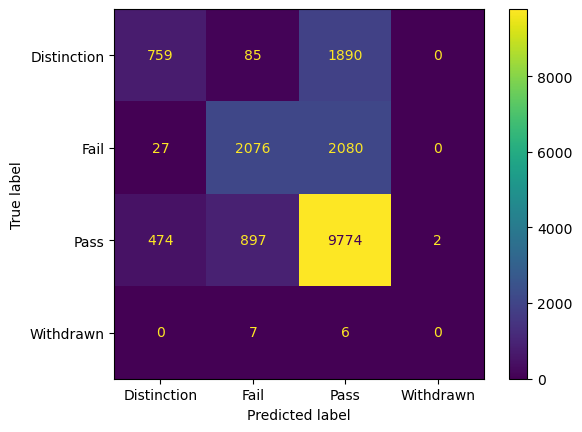

In [92]:
gb_confusion = confusion_matrix(y_test, gb_pred, labels = gb_model.classes_)
gb_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = gb_confusion, display_labels = gb_model.classes_)
gb_confusion_matrix.plot()
plt.show()

In [93]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

 Distinction       0.60      0.28      0.38      2734
        Fail       0.68      0.50      0.57      4183
        Pass       0.71      0.88      0.79     11147
   Withdrawn       0.00      0.00      0.00        13

    accuracy                           0.70     18077
   macro avg       0.50      0.41      0.43     18077
weighted avg       0.69      0.70      0.67     18077



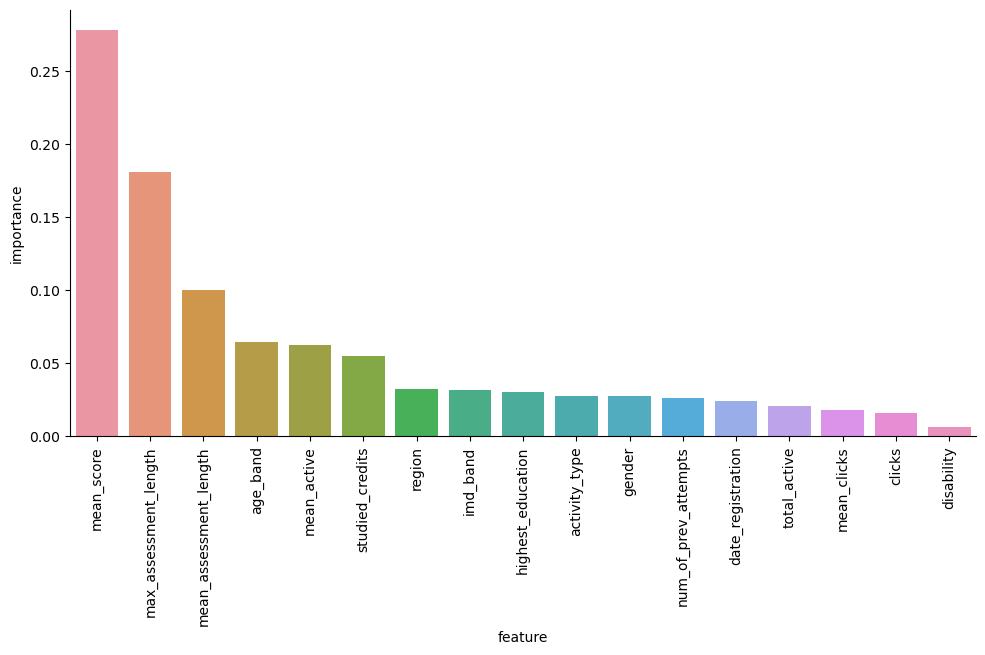

In [94]:
gb_imp = gb_model.feature_importances_
gb_feat_imp_df = pd.DataFrame({'feature': features, 'importance': gb_imp})
gb_sorted = gb_feat_imp_df.sort_values(by = 'importance', ascending = False)
gb_feat_plot = sns.catplot(data = gb_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
gb_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [95]:
print(f'CV time: {gb_cv_time}')
print(f'Fit time: {gb_fit_time}')
print(f'Predict time: {gb_pred_time}')

CV time: 306694.64096951485
Fit time: 121.32101583480835
Predict time: 0.3378009796142578
